<a href="https://colab.research.google.com/github/leticiarccorrea/sales-operations-demand-forecasting/blob/main/case_salesmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import bibliotecas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from google.colab import drive



In [2]:
# import dataset

# Access to Google Drive
drive.mount('/content/drive')
datapah = '/content/drive/MyDrive/caseboti/dataset.csv'
datapah_dic = '/content/drive/MyDrive/caseboti/dicionariodedados.csv'


# Load file in pandas and spark
base = pd.read_csv(datapah, sep=';', on_bad_lines='warn')
base_dictionary = pd.read_csv(datapah_dic)

Mounted at /content/drive


In [3]:
base.head()

,COD_CICLO,FLG_DATA,COD_MATERIAL,COD_CANAL,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,COD_REGIAO,QT_VENDA_BRUTO,QT_DEVOLUCAO,VL_RECEITA_BRUTA,VL_RECEITA_LIQUIDA,FLG_CAMPANHA_MKT_A,FLG_CAMPANHA_MKT_B,FLG_CAMPANHA_MKT_C,FLG_CAMPANHA_MKT_D,FLG_CAMPANHA_MKT_E,PCT_DESCONTO,VL_PRECO
0,201917,1,431148,anon_S0,anon_S2,anon_S3,anon_S1,"11934,000000",414.0,"431869,080000","431869,080000",0,0,0,0,0,NaN,"455,400000"
1,202005,0,177816,anon_S0,anon_S2,anon_S4,anon_S1,"540,000000",252.0,"27743,400000","27743,400000",0,0,0,0,0,NaN,"773,400000"
2,201901,0,171786,anon_S0,anon_S5,anon_S6,anon_S1,"54012,000000",1410.0,"962860,200000","962860,200000",0,1,0,0,0,"35,000000","341,400000"
3,201813,0,177774,anon_S7,anon_S2,anon_S8,anon_S1,"438,000000",NaN,"7608,600000","7608,600000",0,0,0,0,0,NaN,"450,900000"
4,202006,1,446592,anon_S0,anon_S5,anon_S9,anon_S1,"2760,000000",240.0,"83339,400000","83339,400000",0,0,0,0,0,NaN,"431,400000"


In [4]:
base.count()

,0
COD_CICLO,173923
FLG_DATA,173923
COD_MATERIAL,173923
COD_CANAL,173923
DES_CATEGORIA_MATERIAL,173923
DES_MARCA_MATERIAL,173923
COD_REGIAO,173923
QT_VENDA_BRUTO,173923
QT_DEVOLUCAO,87164
VL_RECEITA_BRUTA,173923


In [5]:
# verificação da variedade de features
distinct_count_base = (
    base.nunique(dropna=True)
      .reset_index()
      .rename(columns={
          "index": "column_name",
          0: "distinct_values_count"
      })
      .sort_values("distinct_values_count", ascending=False)
)

distinct_count_base

,column_name,distinct_values_count
10,VL_RECEITA_LIQUIDA,124054
9,VL_RECEITA_BRUTA,119095
7,QT_VENDA_BRUTO,14548
17,VL_PRECO,10867
2,COD_MATERIAL,2252
8,QT_DEVOLUCAO,1043
16,PCT_DESCONTO,528
5,DES_MARCA_MATERIAL,85
0,COD_CICLO,53
4,DES_CATEGORIA_MATERIAL,6


# Análise Exploratória e Descritiva (EDA)

A análise tem como objetivo compreender a estrutura dos dados, avaliar sua qualidade e identificar padrões relevantes para o entendimento do comportamento da demanda.

Nessa etapa, serão analisadas estatísticas descritivas, distribuição das variáveis numéricas, cardinalidade das variáveis categóricas e presença de valores ausentes ou inconsistências.

Além disso, investigar relações entre preço, desconto, campanhas e volume vendido, bem como a variabilidade da demanda ao longo do tempo, permitindo identificar sazonalidade, tendências e segmentos com maior volatilidade.

Essa análise é fundamental para embasar decisões de engenharia de variáveis, definição da granularidade de modelagem e escolha de métricas adequadas, garantindo que as etapas subsequentes de modelagem preditiva fiquem alinhadas tanto ao comportamento estatístico dos dados quanto ao contexto de negócio.



**1. Preparação de dados**

Criação de uma base de trabalho - novas features e data cleaning



In [6]:
# criando uma base para não alterar a original
base_work = base.copy()

# converter colunas numéricas

# Define colunas numéricas
numeric_like_columns = [
    "QT_VENDA_BRUTO",
    "QT_DEVOLUCAO",
    "VL_RECEITA_BRUTA",
    "VL_RECEITA_LIQUIDA",
    "PCT_DESCONTO",
    "VL_PRECO",
]

def parse_ptbr_number(series: pd.Series) -> pd.Series:
    if pd.api.types.is_numeric_dtype(series):
        return series

    # Normaliza tokens ausentes e converte PT-BR - float
    return (
        series.astype(str)
        .str.strip()
        .replace(
            {
                "": np.nan,
                "nan": np.nan,
                "NaN": np.nan,
                "NULL": np.nan,
                "None": np.nan,
            }
        )
        .str.replace(".", "", regex=False)   # remove separador de milhar
        .str.replace(",", ".", regex=False)  # vírgula decimal -> ponto
        .astype(float)
    )

# aplicando na base
for col in numeric_like_columns:
    if col in base_work.columns:
        base_work[col] = parse_ptbr_number(base_work[col])

# Preencher desconto faltante com 0 (assimundo que não teve desconto)
if "PCT_DESCONTO" in base_work.columns:
    base_work["PCT_DESCONTO"] = base_work["PCT_DESCONTO"].fillna(0.0)

    # normalizar desconto para 0–1
    if base_work["PCT_DESCONTO"].max() > 1.0:
        base_work["PCT_DESCONTO"] = base_work["PCT_DESCONTO"] / 100.0

    # Clip de ajuste nos descontos negativos
    base_work["PCT_DESCONTO"] = base_work["PCT_DESCONTO"].clip(lower=0.0)

# Criar uma coluna de demanda líquida: qt vendida - qt devolvida
if "QT_DEVOLUCAO" in base_work.columns:
    base_work["QT_DEVOLUCAO"] = base_work["QT_DEVOLUCAO"].fillna(0.0)
else:
    base_work["QT_DEVOLUCAO"] = 0.0

base_work["qt_venda_liquida"] = base_work["QT_VENDA_BRUTO"] - base_work["QT_DEVOLUCAO"]

# % devolução
base_work["pct_devolucao"] = np.where(
    base_work["QT_VENDA_BRUTO"] > 0,
    base_work["QT_DEVOLUCAO"] / base_work["QT_VENDA_BRUTO"],
    np.nan,
)

# Features de tempo baseada no COD_CICLO (formato: YYYYCC)
base_work["ano"] = (base_work["COD_CICLO"] // 100).astype(int)
base_work["ciclo"] = (base_work["COD_CICLO"] % 100).astype(int)

# Criar colune de flag resumo de campanha
campaign_columns = [c for c in base_work.columns if c.startswith("FLG_CAMPANHA")]

# se não encontrar colunas, cria como 0
if len(campaign_columns) > 0:
    base_work["FLG_CAMPANHA_RESUMO"] = (
        base_work[campaign_columns]
        .fillna(0)
        .max(axis=1)
        .astype(int)
    )
else:
    base_work["FLG_CAMPANHA_RESUMO"] = 0

# 6) Checks finais
cols_to_describe = [c for c in numeric_like_columns if c in base_work.columns]
cols_to_describe += ["qt_venda_liquida", "pct_devolucao", "ano", "ciclo", "FLG_CAMPANHA_RESUMO"]

display(base_work[cols_to_describe].describe())
print("Rows:", len(base_work))
print("Share with campaign:", float(base_work["FLG_CAMPANHA_RESUMO"].mean().round(4)))


,QT_VENDA_BRUTO,QT_DEVOLUCAO,VL_RECEITA_BRUTA,VL_RECEITA_LIQUIDA,PCT_DESCONTO,VL_PRECO,qt_venda_liquida,pct_devolucao,ano,ciclo,FLG_CAMPANHA_RESUMO
count,1.739230e+05,173923.000000,1.739230e+05,1.739230e+05,173923.000000,173923.000000,1.739230e+05,173923.000000,173923.000000,173923.000000,173923.000000
mean,1.050377e+04,246.472968,6.475499e+05,6.421887e+05,0.066075,543.703809,1.025729e+04,0.153472,2019.067800,9.106541,0.326443
std,3.327551e+04,567.751683,2.790452e+06,2.780483e+06,0.110192,243.974723,3.311038e+04,0.278724,0.862823,5.122042,0.468913
min,2.345454e+02,0.000000,2.340600e+02,2.340600e+02,0.000000,234.060000,-3.030000e+03,0.000000,2018.000000,1.000000,0.000000
25%,3.960000e+02,0.000000,6.369720e+03,6.273450e+03,0.000000,389.400000,3.120000e+02,0.000000,2018.000000,5.000000,0.000000
50%,2.070000e+03,234.000000,6.738048e+04,6.663558e+04,0.000000,461.400000,1.914000e+03,0.007645,2019.000000,9.000000,0.000000
75%,8.634000e+03,270.000000,3.468348e+05,3.427422e+05,0.150000,593.400000,8.376000e+03,0.137273,2020.000000,14.000000,1.000000
max,1.865862e+06,31662.000000,2.292459e+08,2.292459e+08,0.350000,5539.620000,1.865862e+06,2.917012,2021.000000,18.000000,1.000000


Rows: 173923
Share with campaign: 0.3264


In [7]:
base_work.head()

,COD_CICLO,FLG_DATA,COD_MATERIAL,COD_CANAL,DES_CATEGORIA_MATERIAL,DES_MARCA_MATERIAL,COD_REGIAO,QT_VENDA_BRUTO,QT_DEVOLUCAO,VL_RECEITA_BRUTA,...,FLG_CAMPANHA_MKT_C,FLG_CAMPANHA_MKT_D,FLG_CAMPANHA_MKT_E,PCT_DESCONTO,VL_PRECO,qt_venda_liquida,pct_devolucao,ano,ciclo,FLG_CAMPANHA_RESUMO
0,201917,1,431148,anon_S0,anon_S2,anon_S3,anon_S1,11934.0,414.0,431869.08,...,0,0,0,0.00,455.4,11520.0,0.034691,2019,17,0
1,202005,0,177816,anon_S0,anon_S2,anon_S4,anon_S1,540.0,252.0,27743.40,...,0,0,0,0.00,773.4,288.0,0.466667,2020,5,0
2,201901,0,171786,anon_S0,anon_S5,anon_S6,anon_S1,54012.0,1410.0,962860.20,...,0,0,0,0.35,341.4,52602.0,0.026105,2019,1,1
3,201813,0,177774,anon_S7,anon_S2,anon_S8,anon_S1,438.0,0.0,7608.60,...,0,0,0,0.00,450.9,438.0,0.000000,2018,13,0
4,202006,1,446592,anon_S0,anon_S5,anon_S9,anon_S1,2760.0,240.0,83339.40,...,0,0,0,0.00,431.4,2520.0,0.086957,2020,6,0


Verificação de qualidade dos dados

In [8]:
# Pontos faltantes
missing_rate = base_work.isna().mean().sort_values(ascending=False)
display(missing_rate.to_frame("missing_rate").head(15))

,missing_rate
COD_CICLO,0.0
FLG_DATA,0.0
COD_MATERIAL,0.0
COD_CANAL,0.0
DES_CATEGORIA_MATERIAL,0.0
DES_MARCA_MATERIAL,0.0
COD_REGIAO,0.0
QT_VENDA_BRUTO,0.0
QT_DEVOLUCAO,0.0
VL_RECEITA_BRUTA,0.0


In [9]:
# Verificações inválidas rápidas
invalid_negative = (base_work["qt_venda_liquida"] < 0).mean()
print("Share of rows with negative net demand:", round(float(invalid_negative), 6))

if "PCT_DESCONTO" in base_work.columns:
    print("Discount percentiles:", base_work["PCT_DESCONTO"].quantile([0.01, 0.5, 0.95, 0.99]).to_dict())


Share of rows with negative net demand: 0.000885
Discount percentiles: {0.01: 0.0, 0.5: 0.0, 0.95: 0.3116, 0.99: 0.35}


In [10]:
# investigando linhas negativas
neg_df = base_work.loc[base_work["qt_venda_liquida"] < 0].copy()

print("Negative rows:", len(neg_df))
print("Total negative net demand:", neg_df["qt_venda_liquida"].sum())
print("Share of total net demand (abs):",
      abs(neg_df["qt_venda_liquida"].sum()) / base_work["qt_venda_liquida"].sum())

display(
    neg_df[["COD_CICLO", "COD_MATERIAL", "QT_VENDA_BRUTO", "QT_DEVOLUCAO", "qt_venda_liquida"]]
    .sort_values("qt_venda_liquida")
    .head(20)
)


Negative rows: 154
Total negative net demand: -40134.0
Share of total net demand (abs): 2.249690142098999e-05


,COD_CICLO,COD_MATERIAL,QT_VENDA_BRUTO,QT_DEVOLUCAO,qt_venda_liquida
149783,202002,446904,3390.0,6420.0,-3030.0
15100,202014,455940,1446.0,4218.0,-2772.0
13602,202002,446904,1752.0,4422.0,-2670.0
88749,202011,466920,2082.0,4044.0,-1962.0
36297,202011,451242,1788.0,3612.0,-1824.0
140998,201911,444552,1260.0,2988.0,-1728.0
144683,201902,177840,3114.0,4470.0,-1356.0
135750,202014,451242,2016.0,3168.0,-1152.0
115826,202002,438678,1266.0,2388.0,-1122.0
41567,202014,455940,780.0,1794.0,-1014.0


A análise exploratória concentrou-se inicialmente em garantir a confiabilidade dos dados e a correta construção das métricas de negócio.

Foi realizada a conversão das colunas numéricas no formato brasileiro e criada a métrica de demanda líquida, que representa o sell-out efetivo ao considerar devoluções. As verificações de qualidade indicaram uma base consistente, com ocorrência residual de demanda negativa, explicada por efeitos operacionais de devolução, e sem evidências de problemas estruturais de dados.

**2. Gráficos da distribuição da demanda**

In [11]:
# separar a base agregada por ciclo
coverage = (
    base_work
    .groupby(["ano", "ciclo"], as_index=False)
    .agg(
        total_vendido=("qt_venda_liquida", "sum"),
        receita_liquida=("VL_RECEITA_LIQUIDA", "sum"),
        n_eventos=("qt_venda_liquida", "size"),
    )
    .sort_values(["ano", "ciclo"])
    .reset_index(drop=True)
)

# índice temporal contínuo
coverage["t"] = np.arange(len(coverage))

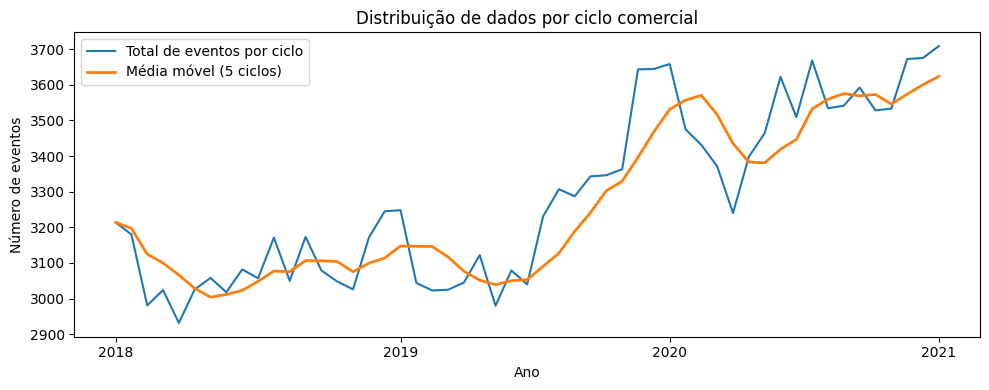

In [12]:
# gráfico da distribuição por pedidos

plt.figure(figsize=(10, 4))

plt.plot(
    coverage["t"],
    coverage["n_eventos"],
    label="Total de eventos por ciclo",
)

plt.plot(
    coverage["t"],
    coverage["n_eventos"].rolling(5, min_periods=1).mean(),
    linewidth=2,
    label="Média móvel (5 ciclos)",
)

# posições onde o ano muda
year_change_idx = coverage.index[coverage["ano"].ne(coverage["ano"].shift())]

# eixo X mostrando apenas os anos
plt.xticks(
    ticks=year_change_idx,
    labels=coverage.loc[year_change_idx, "ano"].astype(str),
)

plt.title("Distribuição de dados por ciclo comercial")
plt.xlabel("Ano")
plt.ylabel("Número de eventos")
plt.legend()
plt.tight_layout()
plt.show()

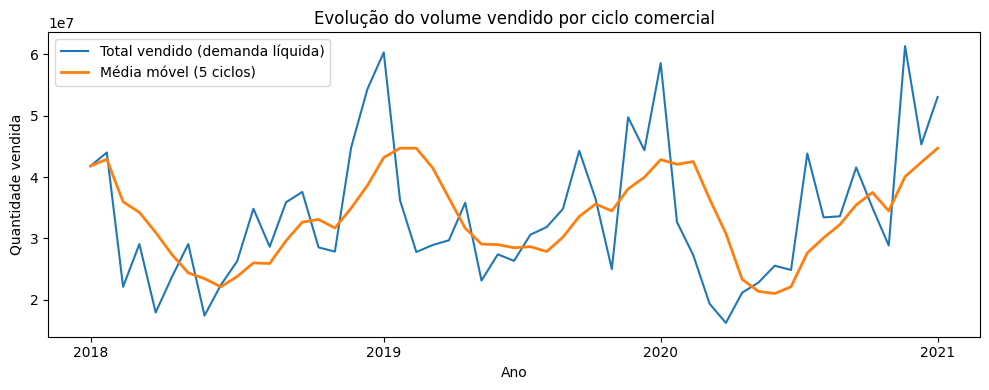

In [13]:
# gráfico 2 — Volume vendido por ciclo
plt.figure(figsize=(10, 4))

plt.plot(
    coverage["t"],
    coverage["total_vendido"],
    label="Total vendido (demanda líquida)",
)

plt.plot(
    coverage["t"],
    coverage["total_vendido"].rolling(5, min_periods=1).mean(),
    linewidth=2,
    label="Média móvel (5 ciclos)",
)

# posições onde o ano muda
year_change_idx = coverage.index[coverage["ano"].ne(coverage["ano"].shift())]

# eixo X mostrando apenas os anos
plt.xticks(
    ticks=year_change_idx,
    labels=coverage.loc[year_change_idx, "ano"].astype(str),
)

plt.title("Evolução do volume vendido por ciclo comercial")
plt.xlabel("Ano")
plt.ylabel("Quantidade vendida")
plt.legend()
plt.tight_layout()
plt.show()


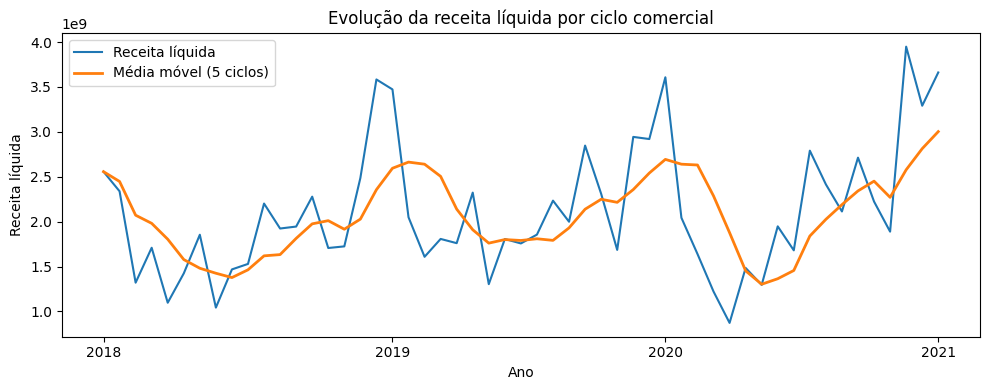

In [14]:
# gráfico 3 — Receita líquida por ciclo

plt.figure(figsize=(10, 4))

plt.plot(
    coverage["t"],
    coverage["receita_liquida"],
    label="Receita líquida",
)

plt.plot(
    coverage["t"],
    coverage["receita_liquida"].rolling(5, min_periods=1).mean(),
    linewidth=2,
    label="Média móvel (5 ciclos)",
)

# posições onde o ano muda
year_change_idx = coverage.index[coverage["ano"].ne(coverage["ano"].shift())]

# eixo X mostrando apenas os anos
plt.xticks(
    ticks=year_change_idx,
    labels=coverage.loc[year_change_idx, "ano"].astype(str),
)

plt.title("Evolução da receita líquida por ciclo comercial")
plt.xlabel("Ano")
plt.ylabel("Receita líquida")
plt.legend()
plt.tight_layout()
plt.show()



,count
discount_bucket,
0,123031
10-20%,24418
20-30%,13155
30-40%,10582
0-10%,2737
40%+,0


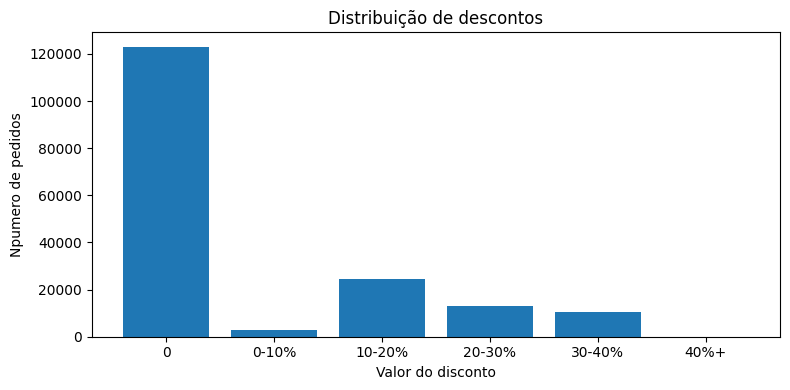

In [15]:
# gráfico de distribuição de descontos

base_work["has_discount"] = (base_work["PCT_DESCONTO"] > 0).astype(int)

base_work["discount_bucket"] = pd.cut(
    base_work["PCT_DESCONTO"],
    bins=[-0.001, 0.0, 0.10, 0.20, 0.30, 0.40, 1.0],
    labels=["0", "0-10%", "10-20%", "20-30%", "30-40%", "40%+"],
)

display(base_work["discount_bucket"].value_counts(dropna=False))

plt.figure(figsize=(8, 4))
bucket_counts = base_work["discount_bucket"].value_counts().sort_index()
plt.bar(bucket_counts.index.astype(str), bucket_counts.values)
plt.title("Distribuição de descontos")
plt.xlabel("Valor do disconto")
plt.ylabel("Npumero de pedidos")
plt.tight_layout()
plt.show()



Os dados foram agregados por ciclo comercial, permitindo analisar a evolução temporal do volume vendido, da receita líquida e da quantidade de eventos.

Os gráficos mostraram estabilidade na cobertura dos dados ao longo dos anos e padrões claros de variação entre ciclos, com o uso de médias móveis para separar oscilações de curto prazo de movimentos mais estruturais.

Por fim, foi avaliado o comportamento dos descontos, que se mostrou altamente concentrado em zero, com poucos casos de descontos elevados. A criação de indicadores binários e faixas de desconto evidenciou que promoções são episódicas, porém relevantes para explicar picos de demanda e possíveis impactos na receita.

**3. Evolução da demanda macro (tendência)**

Demanda agregada ao longo do tempo para visualizar:
Tendência
Picos (eventos/campanhas)
Média móvel (separar sinal de ruído)



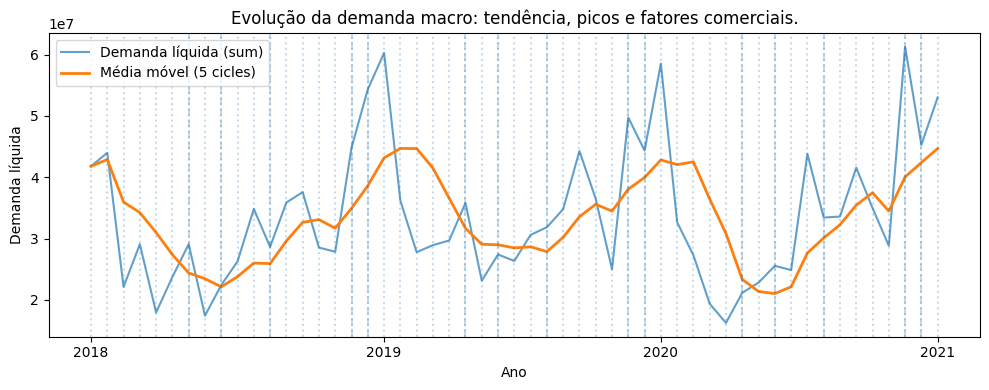

In [16]:
# Agregado por ciclo comercial

group_cols = ["ano", "ciclo"]

ts_total = (
    base_work.groupby(group_cols, as_index=False)
    .agg(
        net_demand=("qt_venda_liquida", "sum"),
        net_revenue=("VL_RECEITA_LIQUIDA", "sum"),
        has_campaign=("FLG_CAMPANHA_RESUMO", "max"),
        has_event=("FLG_DATA", "max") if "FLG_DATA" in base_work.columns else ("FLG_CAMPANHA_RESUMO", "max"),
    )
    .sort_values(group_cols)
    .reset_index(drop=True)
)

# Médias ponderadas
# Pesos = demanda líquida positiva

tmp = base_work.copy()
tmp["weight"] = tmp["qt_venda_liquida"].clip(lower=0)

# Discount weighted average
tmp["discount_x_w"] = tmp["PCT_DESCONTO"].fillna(0.0) * tmp["weight"]
discount_weighted = (
    tmp.groupby(group_cols, as_index=False)
    .agg(discount_num=("discount_x_w", "sum"), weight_sum=("weight", "sum"))
)
discount_weighted["discount_wavg"] = np.where(
    discount_weighted["weight_sum"] > 0,
    discount_weighted["discount_num"] / discount_weighted["weight_sum"],
    0.0,
)
discount_weighted = discount_weighted[group_cols + ["discount_wavg"]]

# Média ponderada de preço
tmp["price_x_w"] = tmp["VL_PRECO"] * tmp["weight"]
price_weighted = (
    tmp.groupby(group_cols, as_index=False)
    .agg(price_num=("price_x_w", "sum"), weight_sum=("weight", "sum"))
)
price_weighted["price_wavg"] = np.where(
    price_weighted["weight_sum"] > 0,
    price_weighted["price_num"] / price_weighted["weight_sum"],
    np.nan,
)
price_weighted = price_weighted[group_cols + ["price_wavg"]]

# Mesclar métricas ponderadas em ts_total
ts_total = (
    ts_total.merge(discount_weighted, on=group_cols, how="left")
            .merge(price_weighted, on=group_cols, how="left")
)


# Índice temporal + média móvel (indicador de tendência)

ts_total["t"] = np.arange(len(ts_total))

window = 5
ts_total["net_demand_roll_mean"] = (
    ts_total["net_demand"].rolling(window=window, min_periods=1).mean()
)


# X-axis - anos
year_change_idx = ts_total.index[ts_total["ano"].ne(ts_total["ano"].shift())]

# Plot

plt.figure(figsize=(10, 4))
plt.plot(ts_total["t"], ts_total["net_demand"], label="Demanda líquida (sum)", alpha=0.7)
plt.plot(
    ts_total["t"],
    ts_total["net_demand_roll_mean"],
    linewidth=2,
    label=f"Média móvel ({window} cicles)",
)

# Ciclos de eventos (tracejado) e os ciclos de campanha (pontilhado).
for idx in ts_total.index[ts_total["has_event"] == 1]:
    plt.axvline(idx, linestyle="--", alpha=0.25)

for idx in ts_total.index[ts_total["has_campaign"] == 1]:
    plt.axvline(idx, linestyle=":", alpha=0.25)

# X-axis - anos
plt.xticks(
    ticks=year_change_idx,
    labels=ts_total.loc[year_change_idx, "ano"].astype(str),
)

plt.title("Evolução da demanda macro: tendência, picos e fatores comerciais.")
plt.xlabel("Ano")
plt.ylabel("Demanda líquida")
handles, labels = plt.gca().get_legend_handles_labels()
if len(labels) > 0:
    plt.legend()
plt.tight_layout()
plt.show()

**4. Análise de sazonalidade**

Sazonalidade foi verificada pelo índice de ciclo (padrão dentro do ano):

Demanda média por número de ciclo
Mapa de calor da demanda (ano x ciclo)

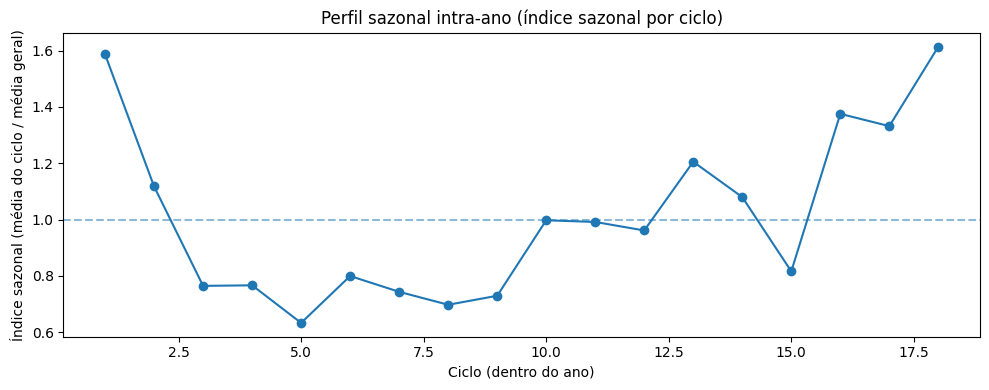

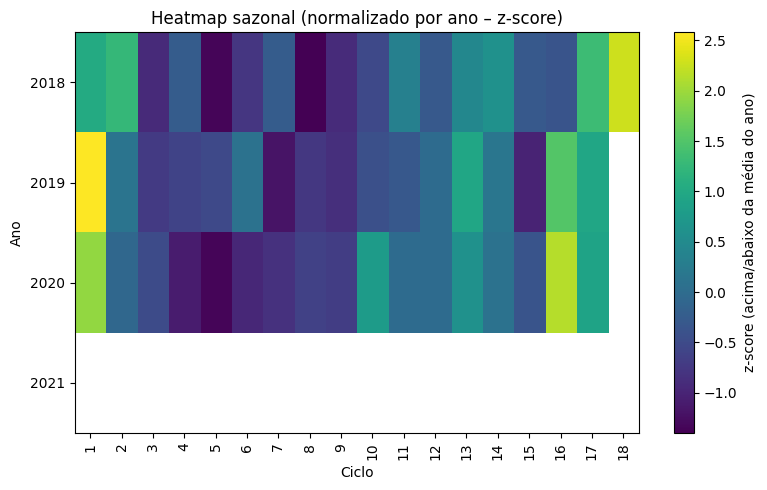

In [17]:
# 1. Perfil sazonal NORMALIZADO (índice sazonal)
# "quanto acima/abaixo do normal" cada ciclo fica


seasonal_profile = (
    ts_total.groupby("ciclo", as_index=False)
    .agg(
        mean_demand=("net_demand", "mean"),
        std_demand=("net_demand", "std"),
        n=("net_demand", "count"),
    )
    .sort_values("ciclo")
)

overall_mean = ts_total["net_demand"].mean()
seasonal_profile["seasonal_index"] = seasonal_profile["mean_demand"] / overall_mean

# (Opcional) banda de incerteza simples: erro padrão (std / sqrt(n))
seasonal_profile["se"] = seasonal_profile["std_demand"] / np.sqrt(seasonal_profile["n"].clip(lower=1))

plt.figure(figsize=(10, 4))
plt.plot(seasonal_profile["ciclo"], seasonal_profile["seasonal_index"], marker="o")

# linha de referência: 1.0 = média geral
plt.axhline(1.0, linestyle="--", alpha=0.5)

plt.title("Perfil sazonal intra-ano (índice sazonal por ciclo)")
plt.xlabel("Ciclo (dentro do ano)")
plt.ylabel("Índice sazonal (média do ciclo / média geral)")
plt.tight_layout()
plt.show()


# 2. Heatmap NORMALIZADO por ano (z-score)
#     - Ver padrões sazonais sem o nível do ano mascarar o desenho
#     - Cada linha (ano) é normalizada: (valor - média do ano) / desvio do ano

heat = (
    ts_total.pivot_table(
        index="ano",
        columns="ciclo",
        values="net_demand",
        aggfunc="sum",
    )
    .sort_index()
)

# normalização por ano (z-score por linha)
row_mean = heat.mean(axis=1)
row_std = heat.std(axis=1).replace(0, np.nan)
heat_z = heat.sub(row_mean, axis=0).div(row_std, axis=0)

plt.figure(figsize=(8, 5))
plt.imshow(heat_z.values, aspect="auto")
plt.title("Heatmap sazonal (normalizado por ano – z-score)")
plt.xlabel("Ciclo")
plt.ylabel("Ano")
plt.colorbar(label="z-score (acima/abaixo da média do ano)")

plt.xticks(
    ticks=np.arange(len(heat.columns)),
    labels=heat.columns,
    rotation=90,
)
plt.yticks(
    ticks=np.arange(len(heat.index)),
    labels=heat.index,
)

plt.tight_layout()
plt.show()



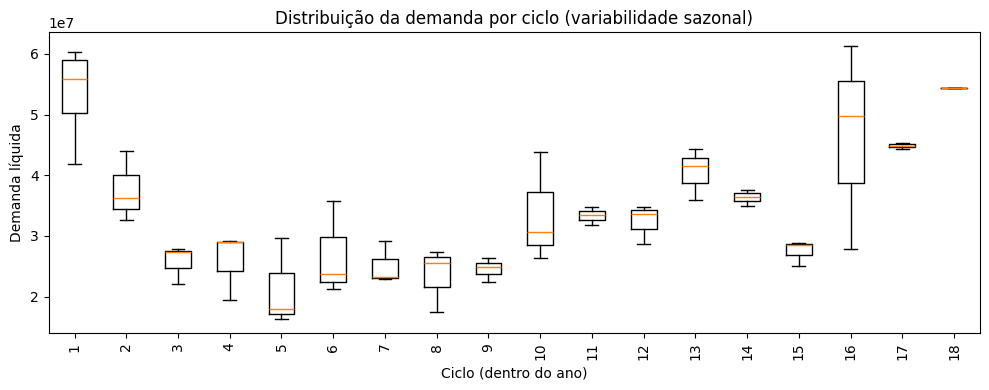

In [18]:
# boxplot por ciclo
plt.figure(figsize=(10, 4))

data_by_cycle = [
    ts_total.loc[ts_total["ciclo"] == c, "net_demand"].values
    for c in sorted(ts_total["ciclo"].unique())
]

plt.boxplot(
    data_by_cycle,
    showfliers=False,
)

plt.xticks(
    ticks=np.arange(1, len(data_by_cycle) + 1),
    labels=sorted(ts_total["ciclo"].unique()),
    rotation=90,
)

plt.title("Distribuição da demanda por ciclo (variabilidade sazonal)")
plt.xlabel("Ciclo (dentro do ano)")
plt.ylabel("Demanda líquida")
plt.tight_layout()
plt.show()

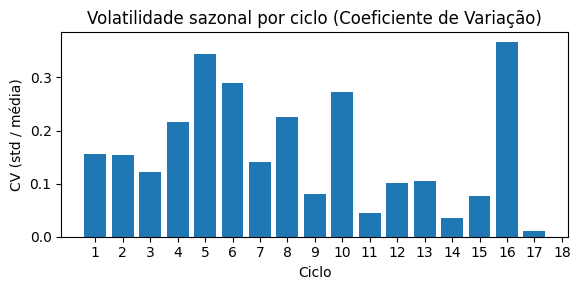

In [19]:
# Coeficiente de variação (CV) por ciclo
# quantifica risco sazonal por ciclo

seasonal_cv = (
    ts_total.groupby("ciclo", as_index=False)
    .agg(
        mean_demand=("net_demand", "mean"),
        std_demand=("net_demand", "std"),
    )
)

seasonal_cv["cv"] = seasonal_cv["std_demand"] / seasonal_cv["mean_demand"]

plt.figure(figsize=(6, 3))
plt.bar(seasonal_cv["ciclo"].astype(str), seasonal_cv["cv"])
plt.title("Volatilidade sazonal por ciclo (Coeficiente de Variação)")
plt.xlabel("Ciclo")
plt.ylabel("CV (std / média)")
plt.tight_layout()
plt.show()


# obs.: alto coeficiente de variação - maior estoque de segurança

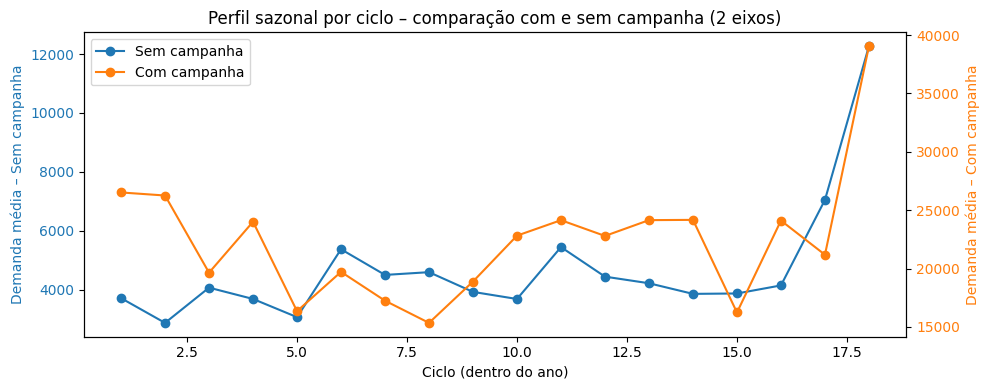

In [20]:
# responder a pergunta : existe sazonalidade sem campanha?


# - Calcula no nível original (base_work) para evitar viés de agregação do ts_total
# - Compara o perfil sazonal médio por ciclo:
#     * Sem campanha (FLG_CAMPANHA_RESUMO = 0)
#     * Com campanha (FLG_CAMPANHA_RESUMO = 1)


# Validação defensiva de colunas necessárias
required_cols = ["ciclo", "qt_venda_liquida", "FLG_CAMPANHA_RESUMO"]
missing_cols = [c for c in required_cols if c not in base_work.columns]
if len(missing_cols) > 0:
    raise ValueError(f"Missing required columns in base_work: {missing_cols}")

# Garantir tipos corretos
base_aux = base_work.copy()
base_aux["FLG_CAMPANHA_RESUMO"] = base_aux["FLG_CAMPANHA_RESUMO"].fillna(0).astype(int)

# Agregação sazonal no nível original
season_campaign = (
    base_aux
    .groupby(["ciclo", "FLG_CAMPANHA_RESUMO"], as_index=False)
    .agg(
        mean_demand=("qt_venda_liquida", "mean"),
        median_demand=("qt_venda_liquida", "median"),
        n=("qt_venda_liquida", "size"),
        std_demand=("qt_venda_liquida", "std"),
    )
    .rename(columns={"FLG_CAMPANHA_RESUMO": "has_campaign"})
    .sort_values(["ciclo", "has_campaign"])
)

# Completar ciclos faltantes (se algum ciclo não tiver um dos grupos 0/1)
all_cycles = sorted(base_aux["ciclo"].dropna().unique().tolist())
full_index = [(c, f) for c in all_cycles for f in [0, 1]]

season_campaign = (
    season_campaign
    .set_index(["ciclo", "has_campaign"])
    .reindex(full_index)
    .reset_index()
)

# Plot das curvas
fig, ax1 = plt.subplots(figsize=(10, 4))
ax2 = ax1.twinx()  # segundo eixo y

# CHANGE: cores explícitas para evitar ambiguidade entre eixos
color_no_campaign = "tab:blue"
color_campaign = "tab:orange"

for flag, label, ax, color in [
    (0, "Sem campanha", ax1, color_no_campaign),
    (1, "Com campanha", ax2, color_campaign),
]:
    df_ = season_campaign[season_campaign["has_campaign"] == flag].sort_values("ciclo")
    ax.plot(
        df_["ciclo"],
        df_["mean_demand"],
        marker="o",
        color=color,          # CHANGE: color definido explicitamente
        label=label,
    )

ax1.set_title("Perfil sazonal por ciclo – comparação com e sem campanha (2 eixos)")
ax1.set_xlabel("Ciclo (dentro do ano)")

ax1.set_ylabel("Demanda média – Sem campanha", color=color_no_campaign)
ax2.set_ylabel("Demanda média – Com campanha", color=color_campaign)

# CHANGE: alinhar cores dos ticks aos respectivos eixos
ax1.tick_params(axis="y", labelcolor=color_no_campaign)
ax2.tick_params(axis="y", labelcolor=color_campaign)

# legenda combinada
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="best")

fig.tight_layout()
plt.show()






A análise de sazonalidade evidencia que a demanda líquida apresenta um padrão recorrente e consistente ao longo dos ciclos do ano, com picos e vales sistemáticos que se repetem independentemente do ano analisado. Ao agrupar a demanda por ciclo (intra-ano) e observar métricas como média e mediana, identifica-se que determinados ciclos concentram volumes estruturalmente mais elevados, enquanto outros apresentam retração persistente. Esse comportamento indica que a variação da demanda não é aleatória, mas fortemente associada a fatores sazonais intrínsecos ao negócio, como calendário comercial, hábitos recorrentes de consumo e dinâmica operacional. A proximidade entre média e mediana na maior parte dos ciclos reforça que esse padrão é relativamente estável, não sendo dominado por poucos outliers, o que caracteriza uma sazonalidade com boa definição.

Ao segmentar essa análise entre períodos com e sem campanha, observa-se que o formato do padrão sazonal permanece praticamente idêntico nas duas situações: os picos e vales de demanda ocorrem nos mesmos ciclos ao longo do ano, independentemente da presença de ações promocionais. Isso demonstra que a sazonalidade é um componente estrutural da demanda, e não um efeito induzido por campanhas.

As campanhas, por sua vez, exercem um papel claro de amplificação do nível da demanda, elevando sistematicamente o volume vendido em todos os ciclos, mas sem alterar a forma da curva sazonal. Em termos analíticos, a campanha atua como um efeito de nível (level shift), enquanto a sazonalidade corresponde ao componente periódico da série temporal. Do ponto de vista de planejamento de demanda e S&OP, isso implica que a sazonalidade deve ser explicitamente incorporada ao baseline dos modelos de forecast, enquanto as campanhas devem ser tratadas como drivers adicionais de uplift incremental.

Interpretar os picos sazonais como consequência direta das campanhas levaria a decisões equivocadas, como subdimensionamento de estoque e capacidade nos ciclos estruturalmente fortes ou excesso de inventário nos ciclos fracos. O resultado reforça que campanhas potencializam uma demanda que já existiria, mas não são sua causa primária, devendo ser planejadas sobre uma base sazonal bem definida para garantir nível de serviço e eficiência de capital.



**5. Impacto de eventos (ciclos comemorativos)**

Estimei o aumento comparando a demanda em:
- ciclos com `FLG_DATA == 1`
- vs. ciclos com `FLG_DATA == 0`



Mean total demand in cycles without event: 32332141.12807895
Mean total demand in cycles with event: 37023843.3642
Estimated uplift (event vs non-event): 0.14510954339632431


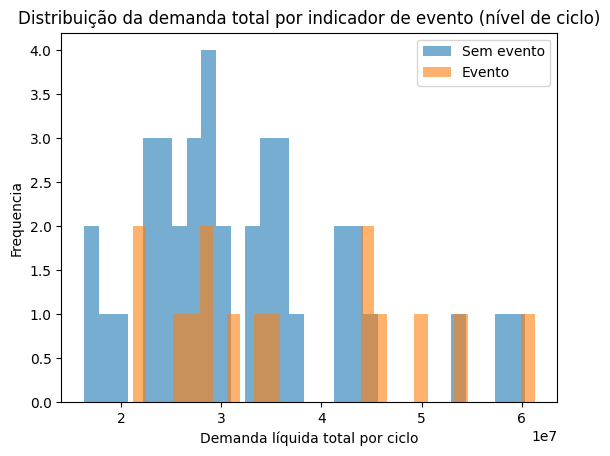

/tmp/ipython-input-3470499159.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["Sem evento", "Evento"], showfliers=False)


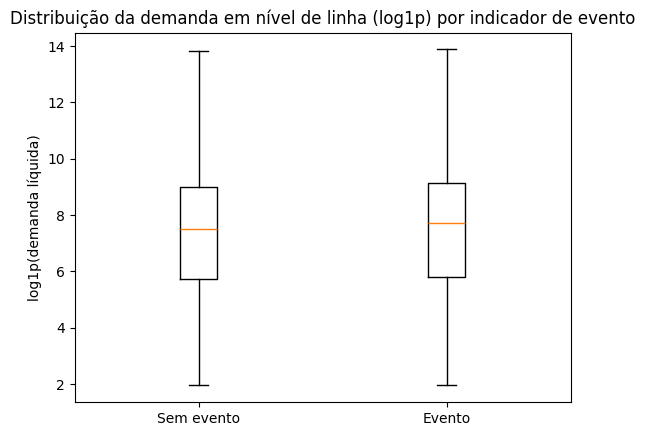

In [21]:
if "FLG_DATA" in base_work.columns:

    # Macro uplift
    ts_event = (
        base_work.groupby(["ano", "ciclo"], as_index=False)
        .agg(
            qt=("qt_venda_liquida", "sum"),
            evento=("FLG_DATA", "max"),
        )
        .sort_values(["ano", "ciclo"])
    )
    event_mean = ts_event.groupby("evento")["qt"].mean()
    uplift = (event_mean.get(1, np.nan) / event_mean.get(0, np.nan) - 1) if 0 in event_mean.index and 1 in event_mean.index else np.nan

    print("Mean total demand in cycles without event:", float(event_mean.get(0, np.nan)))
    print("Mean total demand in cycles with event:", float(event_mean.get(1, np.nan)))
    print("Estimated uplift (event vs non-event):", float(uplift))

    # Plot
    plt.figure()
    plt.hist(ts_event.loc[ts_event["evento"] == 0, "qt"], bins=30, alpha=0.6, label="Sem evento")
    plt.hist(ts_event.loc[ts_event["evento"] == 1, "qt"], bins=30, alpha=0.6, label="Evento")
    plt.title("Distribuição da demanda total por indicador de evento (nível de ciclo)")
    plt.xlabel("Demanda líquida total por ciclo")
    plt.ylabel("Frequencia")
    plt.legend()
    plt.show()

    # Boxplot
    base_work["log_qt"] = np.log1p(np.clip(base_work["qt_venda_liquida"], a_min=0, a_max=None))

    plt.figure()
    data0 = base_work.loc[base_work["FLG_DATA"] == 0, "log_qt"].dropna().values
    data1 = base_work.loc[base_work["FLG_DATA"] == 1, "log_qt"].dropna().values
    plt.boxplot([data0, data1], labels=["Sem evento", "Evento"], showfliers=False)
    plt.title("Distribuição da demanda em nível de linha (log1p) por indicador de evento")
    plt.ylabel("log1p(demanda líquida)")
    plt.show()
else:
    print("A coluna FLG_DATA não foi encontrada no conjunto de dados; análise de eventos ignorada.")


A comparação entre ciclos com e sem eventos comemorativos, no nível agregado de ciclo, mostra que os eventos estão associados a um deslocamento da distribuição da demanda total para valores mais altos, além de uma maior dispersão. No histograma, observa-se que ciclos com evento concentram uma frequência maior em faixas superiores de demanda líquida total, enquanto ciclos sem evento permanecem mais concentrados em níveis intermediários. Isso indica que eventos comemorativos tendem a elevar o volume global vendido no ciclo, mas com maior variabilidade entre ciclos, sugerindo que o impacto do evento não é uniforme e depende de fatores adicionais como mix de produtos, execução comercial e contexto sazonal.

Quando a análise é feita no nível de linha, utilizando a transformação log1p da demanda e representada por boxplots, o padrão se mantém de forma mais robusta. A mediana da demanda em períodos com evento é ligeiramente superior à observada em períodos sem evento, e a distribuição apresenta uma cauda superior mais longa, evidenciando maior probabilidade de volumes elevados por item durante eventos. A transformação logarítmica reduz a influência de outliers e confirma que o efeito observado no nível agregado não é causado apenas por poucos ciclos extremos, mas reflete um efeito sistêmico de aumento de nível.

Os resultados indicam que eventos comemorativos atuam como um driver de uplift de demanda, aumentando o nível médio e a volatilidade, mas sem necessariamente alterar a estrutura fundamental da distribuição, o que reforça a necessidade de tratá-los como variáveis explicativas explícitas nos modelos de forecast e nas decisões de estoque.

**6. Impacto das campanhas (indicadores de marketing)**

`FLG_CAMPANHA_RESUMO`:
- Comparar a demanda e a receita com e sem a campanha
- Verificar a relação com **desconto** e **preço**
- Avaliar o efeito combinado: **evento × campanha**


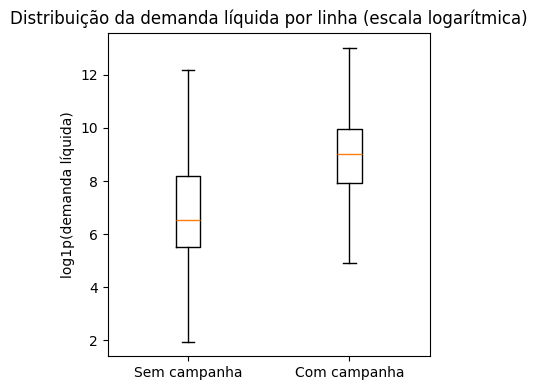

,count,mean,median,std,min,max
FLG_CAMPANHA_RESUMO,,,,,,
Sem campanha,117147,4460.039723,696.0,14028.956860,-3030.0,950052.0
Com campanha,56776,22218.873114,8112.0,52343.401668,-558.0,1865862.0


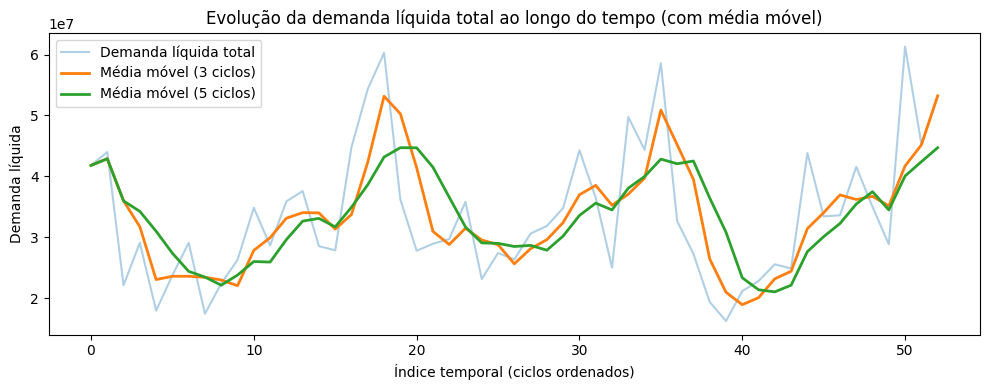

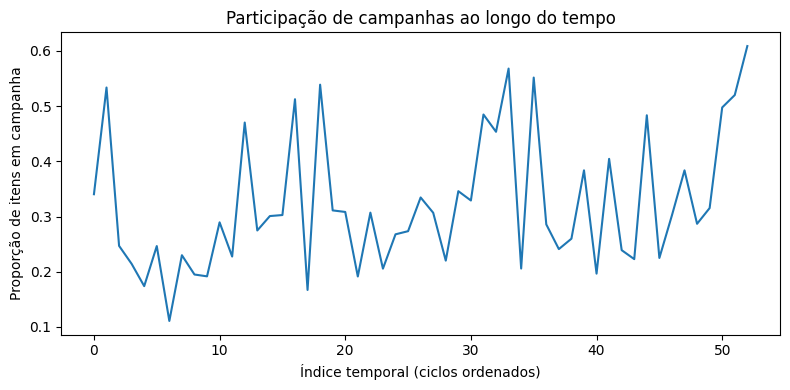

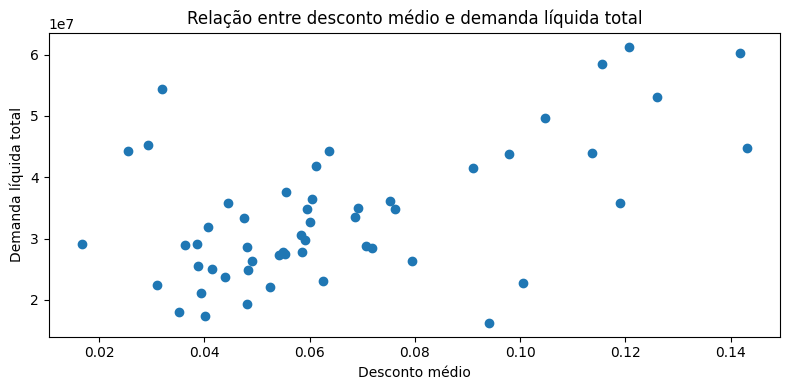

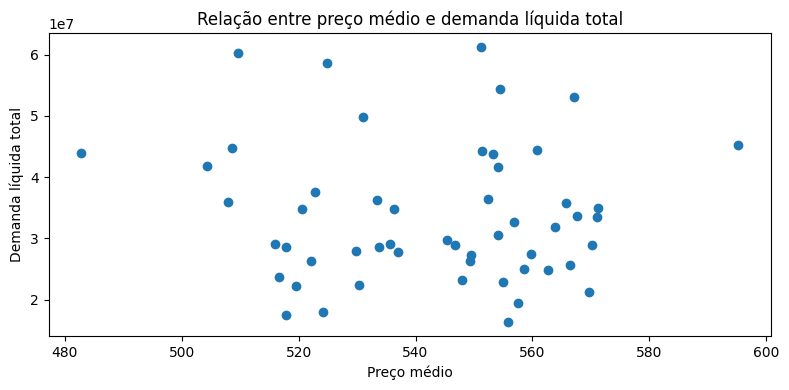

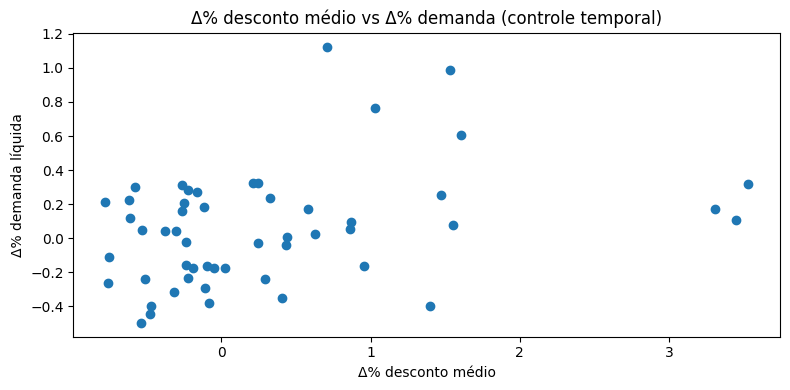

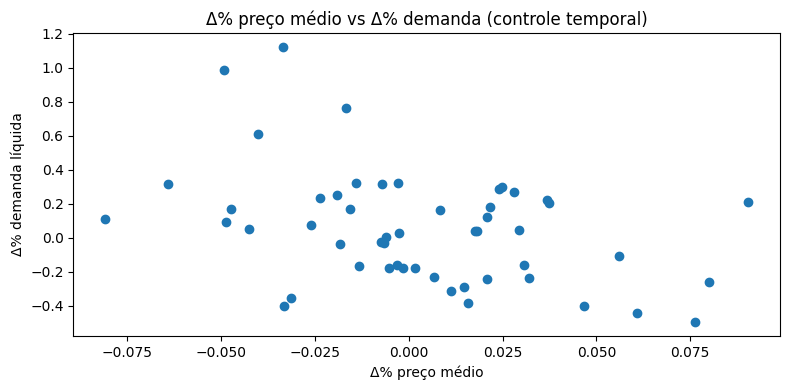

,demanda_media_total,lift_vs_baseline
grupo,,
0_1,3.233214e+07,NaN
1_1,3.702384e+07,NaN


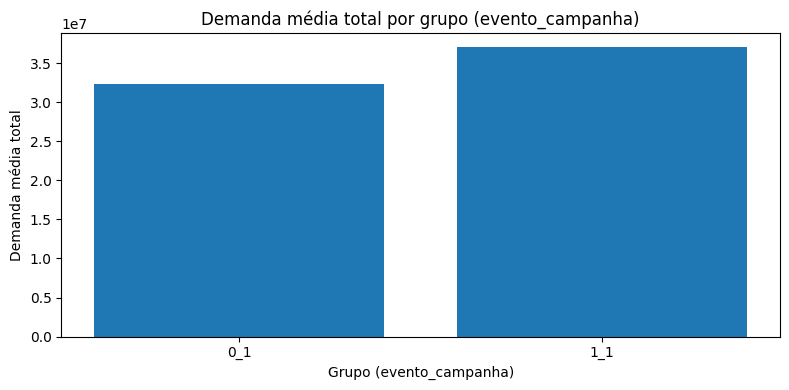

In [22]:
# 1 Análise em nível de linha – distribuição da demanda (log)


# Garantias básicas
base_work["qt_venda_liquida"] = pd.to_numeric(base_work["qt_venda_liquida"], errors="coerce")
base_work["FLG_CAMPANHA_RESUMO"] = pd.to_numeric(
    base_work["FLG_CAMPANHA_RESUMO"], errors="coerce"
).fillna(0).astype(int)

# Escala logarítmica para reduzir assimetria (apenas valores >= 0)
base_work["log_qt"] = np.log1p(np.clip(base_work["qt_venda_liquida"], a_min=0, a_max=None))

data_no_campaign = (
    base_work.loc[base_work["FLG_CAMPANHA_RESUMO"] == 0, "log_qt"]
    .dropna()
    .values
)

data_campaign = (
    base_work.loc[base_work["FLG_CAMPANHA_RESUMO"] == 1, "log_qt"]
    .dropna()
    .values
)

plt.figure(figsize=(4, 4))
plt.boxplot(
    [data_no_campaign, data_campaign],
    tick_labels=["Sem campanha", "Com campanha"],  # parâmetro atualizado
    showfliers=False,
)
plt.title("Distribuição da demanda líquida por linha (escala logarítmica)")
plt.ylabel("log1p(demanda líquida)")
plt.tight_layout()
plt.show()

# Estatísticas resumidas para suportar a leitura visual
micro_summary = (
    base_work.groupby("FLG_CAMPANHA_RESUMO")["qt_venda_liquida"]
    .agg(count="count", mean="mean", median="median", std="std", min="min", max="max")
    .rename(index={0: "Sem campanha", 1: "Com campanha"})
)
display(micro_summary)

# 2 Análise macro por ciclo – demanda, campanha, preço e desconto e inclusão de média móvel


# Garantir numéricos
base_work["PCT_DESCONTO"] = pd.to_numeric(base_work["PCT_DESCONTO"], errors="coerce")
base_work["VL_PRECO"] = pd.to_numeric(base_work["VL_PRECO"], errors="coerce")

ts_campaign = (
    base_work.groupby(["ano", "ciclo"], as_index=False)
    .agg(
        qt=("qt_venda_liquida", "sum"),
        campanha_share=("FLG_CAMPANHA_RESUMO", "mean"),
        desconto_medio=("PCT_DESCONTO", "mean"),
        preco_medio=("VL_PRECO", "mean"),
    )
    .sort_values(["ano", "ciclo"])
    .reset_index(drop=True)
)

ts_campaign["t"] = np.arange(len(ts_campaign))

# Média móvel (3 e 5 ciclos)
ts_campaign["qt_ma_3"] = ts_campaign["qt"].rolling(window=3, min_periods=1).mean()
ts_campaign["qt_ma_5"] = ts_campaign["qt"].rolling(window=5, min_periods=1).mean()

# Demanda total ao longo do tempo
plt.figure(figsize=(10, 4))
plt.plot(ts_campaign["t"], ts_campaign["qt"], alpha=0.35, label="Demanda líquida total")
plt.plot(ts_campaign["t"], ts_campaign["qt_ma_3"], linewidth=2, label="Média móvel (3 ciclos)")
plt.plot(ts_campaign["t"], ts_campaign["qt_ma_5"], linewidth=2, label="Média móvel (5 ciclos)")
plt.title("Evolução da demanda líquida total ao longo do tempo (com média móvel)")
plt.xlabel("Índice temporal (ciclos ordenados)")
plt.ylabel("Demanda líquida")
plt.legend()
plt.tight_layout()
plt.show()

# Participação de campanha ao longo do tempo
plt.figure(figsize=(8, 4))
plt.plot(ts_campaign["t"], ts_campaign["campanha_share"])
plt.title("Participação de campanhas ao longo do tempo")
plt.xlabel("Índice temporal (ciclos ordenados)")
plt.ylabel("Proporção de itens em campanha")
plt.tight_layout()
plt.show()

# 3 Relação entre preço, desconto e demanda (nível de ciclo)


plt.figure(figsize=(8, 4))
plt.scatter(ts_campaign["desconto_medio"], ts_campaign["qt"])
plt.title("Relação entre desconto médio e demanda líquida total")
plt.xlabel("Desconto médio")
plt.ylabel("Demanda líquida total")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.scatter(ts_campaign["preco_medio"], ts_campaign["qt"])
plt.title("Relação entre preço médio e demanda líquida total")
plt.xlabel("Preço médio")
plt.ylabel("Demanda líquida total")
plt.tight_layout()
plt.show()

# Relação controlando tendência via variações percentuais
ts_campaign["qt_pct_change"] = ts_campaign["qt"].pct_change()
ts_campaign["desconto_pct_change"] = ts_campaign["desconto_medio"].pct_change()
ts_campaign["preco_pct_change"] = ts_campaign["preco_medio"].pct_change()

delta_discount = ts_campaign.dropna(subset=["qt_pct_change", "desconto_pct_change"])
plt.figure(figsize=(8, 4))
plt.scatter(delta_discount["desconto_pct_change"], delta_discount["qt_pct_change"])
plt.title("Δ% desconto médio vs Δ% demanda (controle temporal)")
plt.xlabel("Δ% desconto médio")
plt.ylabel("Δ% demanda líquida")
plt.tight_layout()
plt.show()

delta_price = ts_campaign.dropna(subset=["qt_pct_change", "preco_pct_change"])
plt.figure(figsize=(8, 4))
plt.scatter(delta_price["preco_pct_change"], delta_price["qt_pct_change"])
plt.title("Δ% preço médio vs Δ% demanda (controle temporal)")
plt.xlabel("Δ% preço médio")
plt.ylabel("Δ% demanda líquida")
plt.tight_layout()
plt.show()

# 4 Interação Evento x Campanha


if "FLG_DATA" in base_work.columns:
    base_work["FLG_DATA"] = pd.to_numeric(base_work["FLG_DATA"], errors="coerce").fillna(0).astype(int)

    ts_evt_cmp = (
        base_work.groupby(["ano", "ciclo"], as_index=False)
        .agg(
            qt=("qt_venda_liquida", "sum"),
            evento=("FLG_DATA", "max"),
            campanha=("FLG_CAMPANHA_RESUMO", "max"),
        )
        .sort_values(["ano", "ciclo"])
        .reset_index(drop=True)
    )

    ts_evt_cmp["grupo"] = (
        ts_evt_cmp["evento"].astype(int).astype(str)
        + "_"
        + ts_evt_cmp["campanha"].astype(int).astype(str)
    )

    group_mean = (
        ts_evt_cmp.groupby("grupo")["qt"]
        .mean()
        .sort_index()
        .to_frame("demanda_media_total")
    )

    # Lift vs baseline (0_0)
    if "0_0" in group_mean.index and group_mean.loc["0_0", "demanda_media_total"] != 0:
        baseline = group_mean.loc["0_0", "demanda_media_total"]
        group_mean["lift_vs_baseline"] = group_mean["demanda_media_total"] / baseline - 1
    else:
        group_mean["lift_vs_baseline"] = np.nan

    display(group_mean)

    plt.figure(figsize=(8, 4))
    plt.bar(group_mean.index.astype(str), group_mean["demanda_media_total"].values)
    plt.title("Demanda média total por grupo (evento_campanha)")
    plt.xlabel("Grupo (evento_campanha)")
    plt.ylabel("Demanda média total")
    plt.tight_layout()
    plt.show()

    if group_mean["lift_vs_baseline"].notna().any():
        plt.figure(figsize=(8, 4))
        plt.bar(group_mean.index.astype(str), group_mean["lift_vs_baseline"].values)
        plt.title("Lift vs baseline (0_0) por grupo (evento_campanha)")
        plt.xlabel("Grupo (evento_campanha)")
        plt.ylabel("Lift vs baseline")
        plt.tight_layout()
        plt.show()
else:
    print("Coluna 'FLG_DATA' não encontrada: pulando análise Evento x Campanha.")


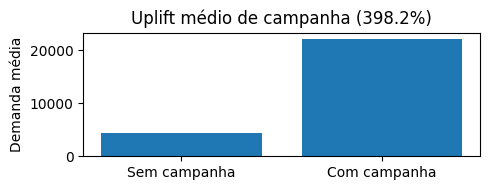

In [23]:
# Uplift de campanha (diferença relativa)
# Quanto a campanha aumenta (ou não) a demanda?

uplift = (
    base_work
    .groupby("FLG_CAMPANHA_RESUMO", as_index=False)
    .agg(mean_demand=("qt_venda_liquida", "mean"))
)

uplift_value = (
    uplift.loc[uplift["FLG_CAMPANHA_RESUMO"] == 1, "mean_demand"].values[0]
    / uplift.loc[uplift["FLG_CAMPANHA_RESUMO"] == 0, "mean_demand"].values[0]
    - 1
)

plt.figure(figsize=(5, 2))
plt.bar(["Sem campanha", "Com campanha"], uplift["mean_demand"].values)
plt.title(f"Uplift médio de campanha ({uplift_value:.1%})")
plt.ylabel("Demanda média")
plt.tight_layout()
plt.show()



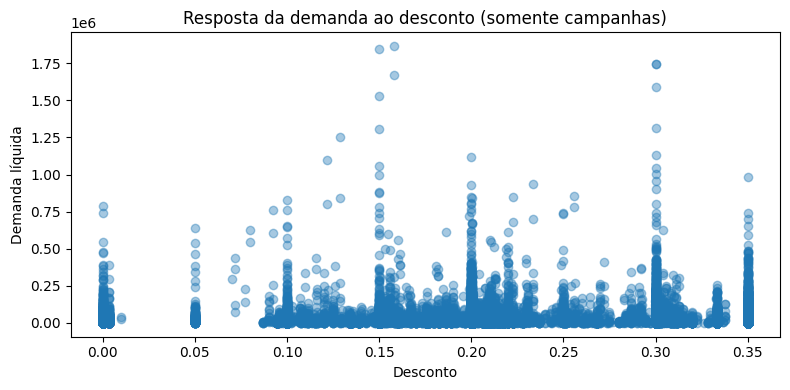

In [24]:
# Curva de resposta a desconto (apenas em campanha)

df_campaign = base_work[base_work["FLG_CAMPANHA_RESUMO"] == 1].copy()

plt.figure(figsize=(8, 4))
plt.scatter(df_campaign["PCT_DESCONTO"], df_campaign["qt_venda_liquida"], alpha=0.4)
plt.title("Resposta da demanda ao desconto (somente campanhas)")
plt.xlabel("Desconto")
plt.ylabel("Demanda líquida")
plt.tight_layout()
plt.show()


A análise integrada dos gráficos evidencia que as campanhas exercem um impacto claro e consistente no nível da demanda, tanto no nível de linha quanto no nível agregado por ciclo.

A distribuição da demanda líquida por linha, analisada em escala logarítmica, mostra um deslocamento significativo da mediana para valores mais elevados nos períodos com campanha, acompanhado de maior dispersão. A transformação logarítmica reduz o efeito de outliers e confirma que o aumento observado não é explicado apenas por poucos registros extremos, mas representa um efeito sistêmico de elevação de nível. Esse mesmo comportamento aparece na distribuição da demanda total por ciclo, na qual ciclos com campanha concentram maior frequência em faixas superiores de volume, reforçando que o impacto da campanha é estrutural e não pontual.

Ao observar a evolução temporal da demanda líquida total, suavizada por médias móveis de diferentes janelas, nota-se a presença de um padrão sazonal recorrente, com picos e vales que se repetem ao longo do tempo. As campanhas atuam principalmente como um fator de amplificação desses picos, elevando a demanda nos ciclos já estruturalmente fortes, mas sem alterar o formato da tendência nem a periodicidade do comportamento temporal. Isso é corroborado pela série que mostra a participação de campanhas ao longo do tempo, a qual varia entre ciclos, mas não explica isoladamente o padrão de alta e baixa da demanda. Assim, o timing da demanda é ditado majoritariamente pela sazonalidade do negócio, enquanto a campanha atua sobre a magnitude do volume vendido.

A relação entre variáveis comerciais e demanda reforça esse diagnóstico. Os gráficos de dispersão indicam uma associação positiva entre desconto médio e demanda líquida total, especialmente em níveis mais elevados de desconto, ainda que com considerável heterogeneidade. Isso sugere que o desconto é um driver relevante de uplift, mas com retorno variável dependendo do contexto, do mix de produtos e da execução da campanha.

A relação entre preço médio e demanda, por sua vez, é mais difusa e menos estável, indicando que o efeito da campanha se dá predominantemente pelo incentivo promocional, e não por mudanças isoladas no nível de preço. Quando se controla a análise temporalmente, observando variações percentuais de desconto e demanda, o padrão positivo se mantém, enquanto o efeito de variações de preço permanece mais fraco e inconsistente.

Por fim, a comparação direta das métricas agregadas evidencia a magnitude do impacto das campanhas, com um uplift médio elevado em relação aos períodos sem campanha. Esse ganho expressivo confirma o potencial das campanhas como alavanca comercial, mas também explica o aumento da variabilidade observado nas distribuições: o impacto não é uniforme entre ciclos e execuções. Do ponto de vista de planejamento de demanda, os resultados indicam que campanhas devem ser tratadas como um componente adicional de uplift sobre um baseline sazonal bem definido, e não como a origem do comportamento da demanda.

Planejar campanhas alinhadas aos ciclos estruturalmente fortes e calibrar sua intensidade é fundamental para capturar o ganho de volume sem comprometer nível de serviço, capacidade operacional e eficiência de capital.

**7. Segmentação de negócios: categoria, canal, região, marca**

Objetivo:
- Identificar quem explica a maior parte da demanda
- Comparar a sazonalidade e a sensibilidade da campanha entre os segmentos

,value,share,cum_share
DES_CATEGORIA_MATERIAL,,,
anon_S12,8.360374e+08,0.468636,0.468636
anon_S2,4.192944e+08,0.235033,0.703670
anon_S5,3.116848e+08,0.174713,0.878383
anon_S11,1.582082e+08,0.088683,0.967066
anon_S18,3.775035e+07,0.021161,0.988226
anon_S30,2.100383e+07,0.011774,1.000000


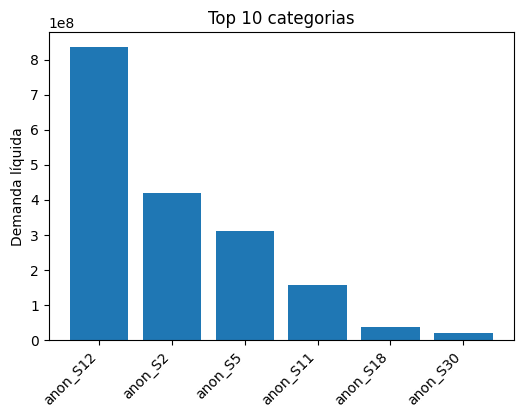

,value,share,cum_share
COD_CANAL,,,
anon_S7,9.884557e+08,0.554074,0.554074
anon_S0,7.955234e+08,0.445926,1.000000


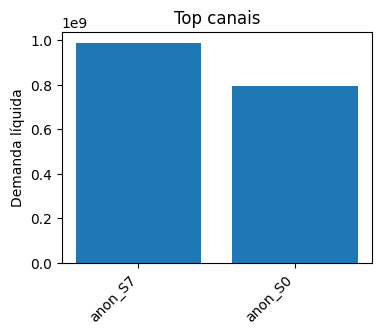

,value,share,cum_share
COD_REGIAO,,,
anon_S1,1.110694e+09,0.622594,0.622594
anon_S10,6.732852e+08,0.377406,1.000000


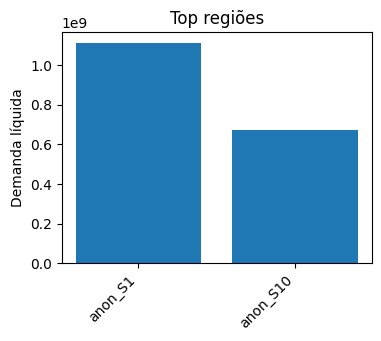

,value,share,cum_share
DES_MARCA_MATERIAL,,,
anon_S8,2.451206e+08,0.137401,0.137401
anon_S24,2.166558e+08,0.121445,0.258846
anon_S20,2.054742e+08,0.115177,0.374024
anon_S22,1.458142e+08,0.081735,0.455759
anon_S23,1.176314e+08,0.065938,0.521697
anon_S4,9.826993e+07,0.055085,0.576782
anon_S21,9.611242e+07,0.053875,0.630657
anon_S25,9.326641e+07,0.052280,0.682937
anon_S17,7.717506e+07,0.043260,0.726197


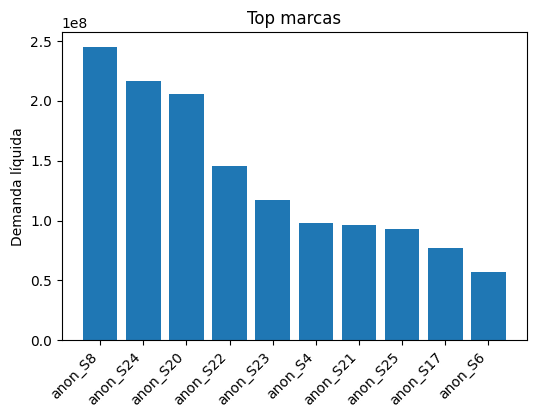

In [32]:
def pareto_share(series: pd.Series, top_n: int = 10) -> pd.DataFrame:
    df_ = series.sort_values(ascending=False).head(top_n).to_frame("value")
    df_["share"] = df_["value"] / series.sum()
    df_["cum_share"] = df_["share"].cumsum()
    return df_

# Categoria
cat_total = base_work.groupby("DES_CATEGORIA_MATERIAL")["qt_venda_liquida"].sum().sort_values(ascending=False)
display(pareto_share(cat_total, top_n=10))

plt.figure(figsize=(6, 4))
plt.bar(cat_total.head(10).index.astype(str), cat_total.head(10).values)
plt.title("Top 10 categorias")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Demanda líquida")
plt.show()

# Canal
canal_total = base_work.groupby("COD_CANAL")["qt_venda_liquida"].sum().sort_values(ascending=False)
display(pareto_share(canal_total, top_n=10))

plt.figure(figsize=(4, 3))
plt.bar(canal_total.head(10).index.astype(str), canal_total.head(10).values)
plt.title("Top canais")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Demanda líquida")
plt.show()

# Região
reg_total = base_work.groupby("COD_REGIAO")["qt_venda_liquida"].sum().sort_values(ascending=False)
display(pareto_share(reg_total, top_n=10))

plt.figure(figsize=(4, 3))
plt.bar(reg_total.head(10).index.astype(str), reg_total.head(10).values)
plt.title("Top regiões")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Demanda líquida")
plt.show()

# Marca
brand_total = base_work.groupby("DES_MARCA_MATERIAL")["qt_venda_liquida"].sum().sort_values(ascending=False)
display(pareto_share(brand_total, top_n=10))

plt.figure(figsize=(6, 4))
plt.bar(brand_total.head(10).index.astype(str), brand_total.head(10).values)
plt.title("Top marcas")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Demanda líquida")
plt.show()


Observando os gráficos de região, canal, categoria de material e marca, fica claro que a demanda líquida não é homogênea e apresenta forte concentração estrutural em poucos eixos do negócio.

No recorte regional, a diferença entre as duas principais regiões é expressiva, com a líder concentrando algo próximo de dois terços da demanda líquida. Isso indica que o comportamento agregado do sistema é altamente dependente dessa região dominante. Em termos de impacto, qualquer erro de previsão, ruptura logística ou mudança estrutural nessa região tende a contaminar de forma desproporcional os KPIs globais (WAPE total, nível de serviço, estoque médio). Para modelagem, isso sugere que a região deve ser tratada explicitamente como uma dimensão-chave, seja via modelos hierárquicos, seja com efeitos específicos, evitando que padrões locais sejam diluídos em um modelo excessivamente agregado.

Quando analisamos o canal, o padrão é semelhante, mas com uma assimetria um pouco menor. Tendo um impacto menor. Na prática, isso significa que erros percentuais similares em canais diferentes produzem impactos absolutos distintos em termos de unidades e capital empatado.

A categoria de material apresenta o efeito mais claro de concentração via Pareto. As três principais categorias explicam a maior parte da demanda líquida, enquanto as demais têm contribuição marginal. Esse resultado é crítico do ponto de vista analítico: categorias líderes tendem a ter séries mais estáveis, com melhor sinal estatístico, enquanto as categorias de cauda longa são mais ruidosas e intermitentes.
O impacto direto disso é na estratégia de modelagem e forecast: faz sentido investir modelos mais sofisticados e calibrados para as categorias core, enquanto abordagens mais simples ou agregadas podem ser suficientes (e até mais robustas) para categorias de baixo volume, reduzindo overfitting e custo operacional.

Por fim, o gráfico de marcas mostra uma distribuição mais pulverizada, sem uma dominância tão extrema quanto região ou categoria, mas ainda assim com clara hierarquia entre as líderes e o restante. Isso sugere que a marca atua como um fator de refinamento da demanda dentro das categorias, influenciando o mix e a variabilidade, mais do que o volume total agregado.
Em termos de impacto, marcas líderes são candidatas naturais a análises mais profundas de elasticidade, campanhas e sazonalidade, enquanto marcas menores podem ser tratadas de forma mais agregada ou como parte de clusters comportamentais.



,abc_xyz,n_skus,total_demand,mean_cv,median_cv
2,A-Z,296,1.154247e+09,1.491779,1.374540
1,A-Y,61,2.703635e+08,0.882244,0.903029
4,B-Z,274,2.409151e+08,1.612879,1.407186
7,C-Z,848,7.414310e+07,1.617466,1.410075
3,B-Y,31,2.677859e+07,0.907800,0.917888
6,C-Y,375,1.427257e+07,0.781747,0.803762
0,A-X,1,2.407470e+06,0.442544,0.442544
5,C-X,366,8.512601e+05,0.158222,0.028221


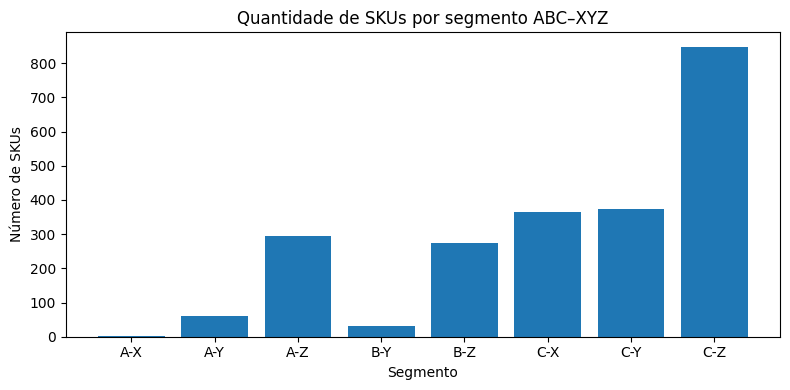

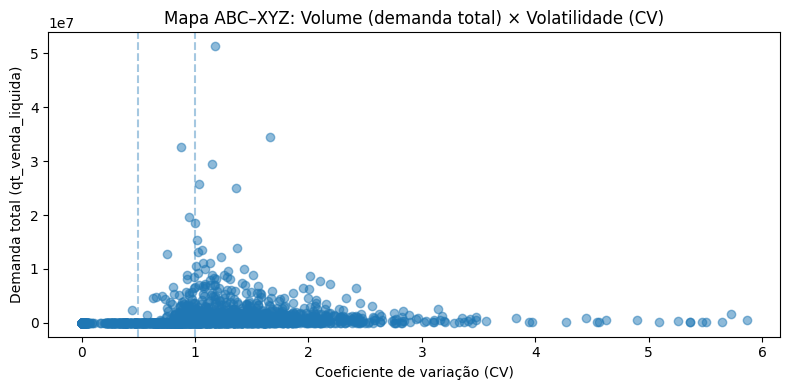

,COD_MATERIAL,total_demand,mean_demand,std_demand,n,cv,share,cum_share,abc_class,xyz_class,abc_xyz
0,177396,5.133694e+07,242155.358491,284614.193034,212,1.175337,0.028777,0.028777,A,Z,A-Z
1,69198,3.453648e+07,162907.908577,270576.597962,212,1.660918,0.019359,0.048136,A,Z,A-Z
3,441876,2.948054e+07,258601.263158,297330.319638,114,1.149764,0.016525,0.082937,A,Z,A-Z
4,152982,2.576795e+07,121546.952830,126312.219326,212,1.039205,0.014444,0.097381,A,Z,A-Z
5,125286,2.499652e+07,118466.900474,161612.258839,211,1.364198,0.014012,0.111392,A,Z,A-Z
7,153066,1.851975e+07,87357.323672,87648.044151,212,1.003328,0.010381,0.132760,A,Z,A-Z
8,146952,1.533833e+07,79063.563730,80702.920692,194,1.020735,0.008598,0.141358,A,Z,A-Z
9,173652,1.392449e+07,65681.547170,89786.275190,212,1.366994,0.007805,0.149163,A,Z,A-Z
10,153084,1.351343e+07,63742.613208,67478.315594,212,1.058606,0.007575,0.156738,A,Z,A-Z
11,136050,1.309627e+07,61774.839623,63438.696971,212,1.026934,0.007341,0.164079,A,Z,A-Z


In [26]:
# mais validações
# 1 Validação defensiva

required_cols = ["COD_MATERIAL", "qt_venda_liquida"]
missing_cols = [c for c in required_cols if c not in base_work.columns]
if len(missing_cols) > 0:
    raise ValueError(f"Missing required columns in base_work: {missing_cols}")


# 2 Estatísticas por SKU/material

sku_stats = (
    base_work
    .groupby("COD_MATERIAL", as_index=False)
    .agg(
        total_demand=("qt_venda_liquida", "sum"),
        mean_demand=("qt_venda_liquida", "mean"),
        std_demand=("qt_venda_liquida", "std"),
        n=("qt_venda_liquida", "size"),
    )
)

# CV (volatilidade relativa)
sku_stats["cv"] = np.where(
    sku_stats["mean_demand"] > 0,
    sku_stats["std_demand"] / sku_stats["mean_demand"],
    np.nan,
)


# 3 Classificação ABC (Pareto por volume)
#     A: até 80%
#     B: 80–95%
#     C: 95–100%
# -------------------------
sku_stats = sku_stats.sort_values("total_demand", ascending=False).reset_index(drop=True)
total_sum = sku_stats["total_demand"].sum()

sku_stats["share"] = np.where(total_sum > 0, sku_stats["total_demand"] / total_sum, np.nan)
sku_stats["cum_share"] = sku_stats["share"].cumsum()

sku_stats["abc_class"] = np.select(
    [
        sku_stats["cum_share"] <= 0.80,
        sku_stats["cum_share"] <= 0.95,
    ],
    ["A", "B"],
    default="C",
)


# 4 Classificação XYZ (por volatilidade)
#     X: CV <= 0.5
#     Y: 0.5 < CV <= 1.0
#     Z: CV > 1.0

sku_stats["xyz_class"] = np.select(
    [
        sku_stats["cv"] <= 0.50,
        sku_stats["cv"] <= 1.00,
    ],
    ["X", "Y"],
    default="Z",
)

# 5 Classe combinada
sku_stats["abc_xyz"] = sku_stats["abc_class"] + "-" + sku_stats["xyz_class"]

# 5 Tabela resumo por segmento (para decisão)

summary_abc_xyz = (
    sku_stats
    .groupby("abc_xyz", as_index=False)
    .agg(
        n_skus=("COD_MATERIAL", "count"),
        total_demand=("total_demand", "sum"),
        mean_cv=("cv", "mean"),
        median_cv=("cv", "median"),
    )
    .sort_values("total_demand", ascending=False)
)

display(summary_abc_xyz)


# 6 Distribuição de SKUs por segmento

segment_counts = sku_stats["abc_xyz"].value_counts().sort_index()

plt.figure(figsize=(8, 4))
plt.bar(segment_counts.index.astype(str), segment_counts.values)
plt.title("Quantidade de SKUs por segmento ABC–XYZ")
plt.xlabel("Segmento")
plt.ylabel("Número de SKUs")
plt.tight_layout()
plt.show()


# 7 Mapa Volume x Volatilidade (scatter)
#     - eixo Y: demanda total
#     - eixo X: CV
#     - linhas verticais: thresholds XYZ

plt.figure(figsize=(8, 4))
plt.scatter(
    sku_stats["cv"],
    sku_stats["total_demand"],
    alpha=0.5,
)

plt.axvline(0.50, linestyle="--", alpha=0.4)
plt.axvline(1.00, linestyle="--", alpha=0.4)

plt.title("Mapa ABC–XYZ: Volume (demanda total) × Volatilidade (CV)")
plt.xlabel("Coeficiente de variação (CV)")
plt.ylabel("Demanda total (qt_venda_liquida)")
plt.tight_layout()
plt.show()


# 8 Lista de SKUs críticos (A-Z) – alto volume e alta volatilidade

critical_az = (
    sku_stats[sku_stats["abc_xyz"] == "A-Z"]
    .sort_values(["total_demand", "cv"], ascending=[False, False])
    .head(30)
)

display(critical_az)



O gráfico de quantidade de SKUs por segmento ABC-XYZ deixa evidente uma assimetria estrutural importante no portfólio. Os segmentos C-Z, C-Y e C-X concentram a maior parte dos SKUs, indicando um portfólio longo, de baixo impacto individual e, em geral, maior imprevisibilidade.
Em contraste, os segmentos A-X e A-Y têm pouquíssimos SKUs, o que é esperado, pois combinam alto volume com baixa variabilidade. Do ponto de vista de negócio, isso reforça que a complexidade operacional não está nos itens críticos de faturamento, mas sim na cauda do portfólio, que consome esforço de planejamento, espaço logístico e atenção operacional desproporcional ao seu retorno financeiro.

Ao relacionar essa visão com o mapa ABC-XYZ (demanda total vs coeficiente de variação), observa-se um padrão clássico de trade-off entre volume e incerteza. Os itens de maior demanda tendem a se concentrar em regiões de baixo CV, formando o núcleo A-X/A-Y, onde o sinal estatístico é forte e previsões tendem a ser mais estáveis. À medida que o CV aumenta, a demanda total cai rapidamente, evidenciando que a maior parte dos itens voláteis são também de baixo volume. Esse padrão é crucial para decisões de forecast: tentar obter alta acurácia absoluta em itens de CV elevado e baixo volume gera pouco ganho marginal e alto risco de overfitting.

A grande massa de pontos concentrada em baixo volume e CV moderado a alto confirma que o segmento C-Z não é apenas numeroso, mas também estatisticamente ruidoso. Em termos de impacto, esses itens são os principais responsáveis por instabilidade de estoque, excesso de parametrização e decisões reativas.
A ideia não é prever melhor todos os SKUs, mas sim estratificar decisões: itens A-X e A-Y justificam modelos dedicados, revisões frequentes e metas agressivas de nível de serviço, enquanto itens C-Z são candidatos naturais a políticas mais simples, como forecast por agregação, reposição por regras ou até descontinuação seletiva.

Em conjunto, os dois gráficos se complementam ao mostrar que volume, variabilidade e complexidade não andam juntos. O risco financeiro está concentrado em poucos SKUs estáveis, enquanto o risco operacional está diluído em muitos SKUs instáveis e de baixo impacto.
Essa distinção é fundamental para a estratégia de planejamento baseada em priorização por valor e risco, e não em tratamento uniforme do portfólio.

**8. Volatilidade da demanda (o principal fator para estoque de segurança e risco)**

Avaliei a volatilidade em 3 níveis:
1. **Volatilidade total da demanda** ao longo do tempo (desvio padrão móvel / CV)
2. **Volatilidade por SKU** (CV entre ciclos) → identificar itens instáveis
3. **Volatilidade por segmento** (categoria/canal/região) para priorizar estratégias de previsão


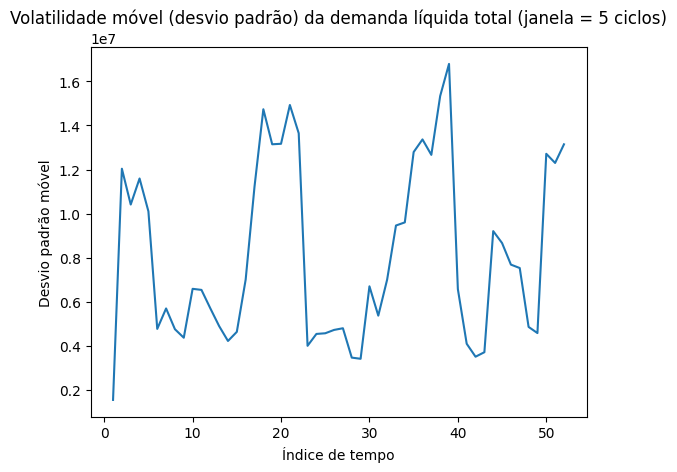

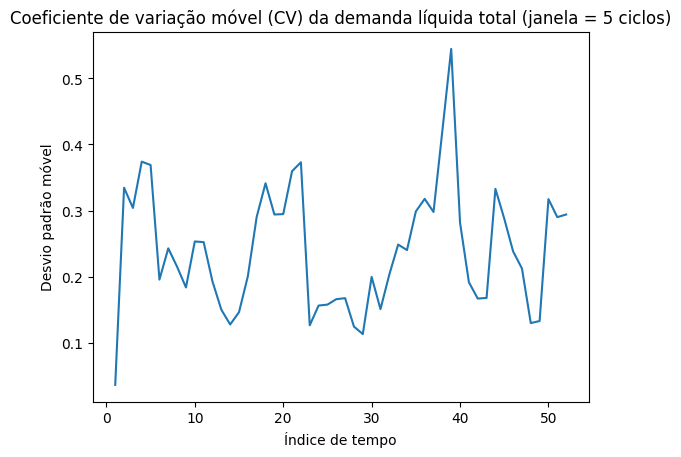

,COD_MATERIAL,mean,std,n,cv
751,113616,3404.100000,18208.023112,40,5.348851
1148,150534,16405.263158,85253.135176,38,5.196694
2072,462270,15813.486486,74206.820362,37,4.692629
1316,166590,31588.641509,147841.022867,53,4.680196
249,63450,2930.153846,12796.608962,39,4.367214
754,113646,5479.736842,23235.871086,38,4.240326
247,63438,11092.304348,45726.925646,46,4.122401
1901,448590,9801.818182,39416.658069,22,4.021362
1903,448608,10569.818182,40492.692613,22,3.830973
1519,422076,6729.545455,25042.001061,22,3.721202


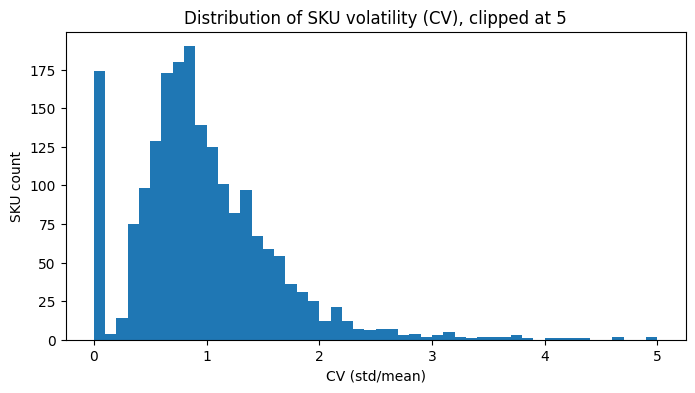

,DES_CATEGORIA_MATERIAL,mean,std,n,cv
4,anon_S30,3.962987e+05,2.154559e+05,53,0.543671
2,anon_S18,7.122707e+05,3.271549e+05,53,0.459313
0,anon_S11,2.985060e+06,1.312140e+06,53,0.439569
3,anon_S2,7.911215e+06,3.167684e+06,53,0.400404
5,anon_S5,5.880846e+06,2.103867e+06,53,0.357749
1,anon_S12,1.577429e+07,5.545000e+06,53,0.351521


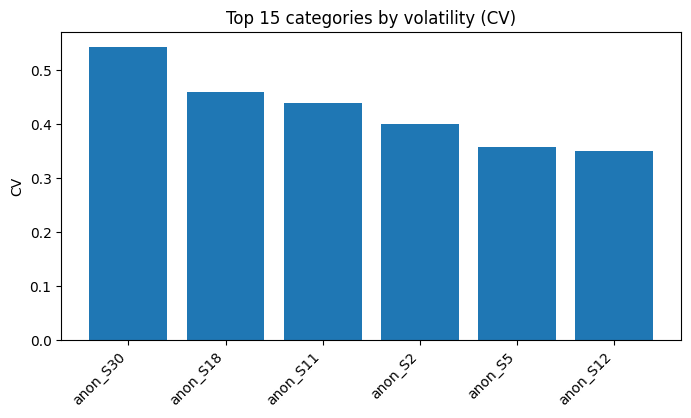

In [27]:
# Volatilidade contínua na demanda total
ts_total2 = ts_total.copy()
ts_total2["roll_std"] = ts_total2["net_demand"].rolling(window=5, min_periods=2).std()
ts_total2["roll_cv"] = ts_total2["roll_std"] / ts_total2["net_demand"].rolling(window=5, min_periods=2).mean()

plt.figure()
plt.plot(ts_total2["t"], ts_total2["roll_std"])
plt.title("Volatilidade móvel (desvio padrão) da demanda líquida total (janela = 5 ciclos)")
plt.xlabel("Índice de tempo")
plt.ylabel("Desvio padrão móvel")
plt.show()

plt.figure()
plt.plot(ts_total2["t"], ts_total2["roll_cv"])
plt.title("Coeficiente de variação móvel (CV) da demanda líquida total (janela = 5 ciclos)")
plt.xlabel("Índice de tempo")
plt.ylabel("Desvio padrão móvel")
plt.show()

# SKU-level volatilidade
sku_cycle = (
    base_work.groupby(["COD_MATERIAL", "ano", "ciclo"], as_index=False)
    .agg(qt=("qt_venda_liquida", "sum"))
)

sku_stats = (
    sku_cycle.groupby("COD_MATERIAL")["qt"]
    .agg(mean="mean", std="std", n="count")
    .reset_index()
)
sku_stats["cv"] = sku_stats["std"] / sku_stats["mean"]
sku_stats = sku_stats.replace([np.inf, -np.inf], np.nan).dropna(subset=["cv"])

display(sku_stats.sort_values("cv", ascending=False).head(20))

plt.figure(figsize=(8, 4))
plt.hist(sku_stats["cv"].clip(upper=5), bins=50)
plt.title("Distribution of SKU volatility (CV), clipped at 5")
plt.xlabel("CV (std/mean)")
plt.ylabel("SKU count")
plt.show()

# Volatilidade por categoria
cat_cycle = (
    base_work.groupby(["DES_CATEGORIA_MATERIAL", "ano", "ciclo"], as_index=False)
    .agg(qt=("qt_venda_liquida", "sum"))
)
cat_stats = (
    cat_cycle.groupby("DES_CATEGORIA_MATERIAL")["qt"]
    .agg(mean="mean", std="std", n="count")
    .reset_index()
)
cat_stats["cv"] = cat_stats["std"] / cat_stats["mean"]
cat_stats = cat_stats.replace([np.inf, -np.inf], np.nan).dropna(subset=["cv"]).sort_values("cv", ascending=False)

display(cat_stats.head(15))

plt.figure(figsize=(8, 4))
plt.bar(cat_stats.head(15)["DES_CATEGORIA_MATERIAL"].astype(str), cat_stats.head(15)["cv"].values)
plt.title("Top 15 categories by volatility (CV)")
plt.xticks(rotation=45, ha="right")
plt.ylabel("CV")
plt.show()

Os gráficos mostram que a volatilidade da demanda é um fenômeno dinâmico, heterogêneo e estrutural, e não apenas um ruído estatístico pontual. O desvio padrão móvel evidencia que a variabilidade da demanda muda ao longo do tempo, com períodos de relativa estabilidade intercalados por janelas de alta incerteza. Isso é crítico para planejamento, pois invalida a suposição de variância constante: utilizar um único parâmetro de variabilidade para todo o horizonte tende a subestimar o risco em fases mais turbulentas e a superestimar estoque em fases estáveis.

O coeficiente de variação móvel (CV) reforça essa leitura ao normalizar o desvio padrão pelo nível médio de demanda. Observa-se que existem picos claros de CV, indicando momentos em que a demanda se torna proporcionalmente muito mais instável, mesmo que o volume absoluto não seja o maior da série. Esses picos são particularmente relevantes para decisões de estoque de segurança, pois o risco de ruptura é função direta da variabilidade relativa durante o lead time. Em termos práticos, isso sugere que políticas estáticas de safety stock são estruturalmente ineficientes em ambientes com volatilidade não estacionária.

A distribuição do CV por SKU mostra um comportamento fortemente assimétrico, com concentração de itens em níveis baixos a moderados de volatilidade e uma cauda longa de SKUs altamente instáveis. Esse padrão confirma que poucos itens são responsáveis pela maior parte do risco operacional, apesar de, muitas vezes, não representarem grande volume de vendas. Do ponto de vista de gestão de portfólio, essa cauda longa é o principal motor de complexidade logística, consumo de capital ineficiente e decisões reativas de reabastecimento.

Quando analisamos as categorias com maior CV, fica evidente que a volatilidade não está distribuída aleatoriamente, mas associada a grupos específicos de produtos. Categorias com CV elevado exigem níveis de estoque de segurança desproporcionalmente maiores para atingir o mesmo nível de serviço, o que pressiona capital de giro e aumenta o risco de obsolescência. Isso reforça que a variável “categoria” é um forte proxy de risco, devendo ser incorporada explicitamente tanto na modelagem quanto nas regras de planejamento.


**9. Correlações e fatores comerciais (preço/desconto)**

Fatores numéricos:
- `qt_venda_liquida`
- `VL_PRECO`
- `PCT_DESCONTO`
- `VL_RECEITA_LIQUIDA`
- `pct_devolucao`
- `FLG_CAMPANHA_RESUMO`


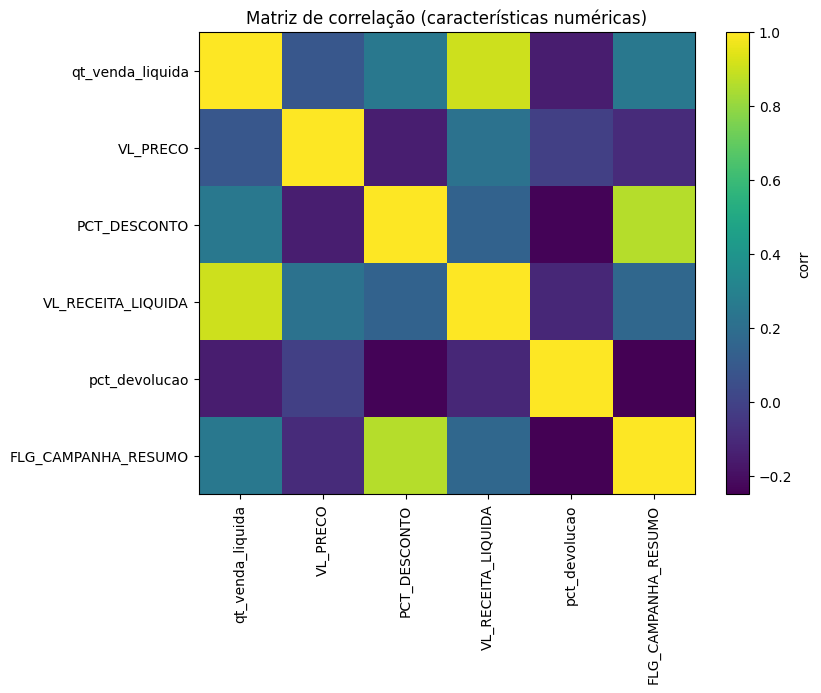

,qt_venda_liquida,VL_PRECO,PCT_DESCONTO,VL_RECEITA_LIQUIDA,pct_devolucao,FLG_CAMPANHA_RESUMO
qt_venda_liquida,1.000000,0.088679,0.249118,0.906034,-0.149003,0.251503
VL_PRECO,0.088679,1.000000,-0.142998,0.219852,-0.012715,-0.093042
PCT_DESCONTO,0.249118,-0.142998,1.000000,0.143241,-0.235548,0.861256
VL_RECEITA_LIQUIDA,0.906034,0.219852,0.143241,1.000000,-0.110519,0.167466
pct_devolucao,-0.149003,-0.012715,-0.235548,-0.110519,1.000000,-0.249093
FLG_CAMPANHA_RESUMO,0.251503,-0.093042,0.861256,0.167466,-0.249093,1.000000


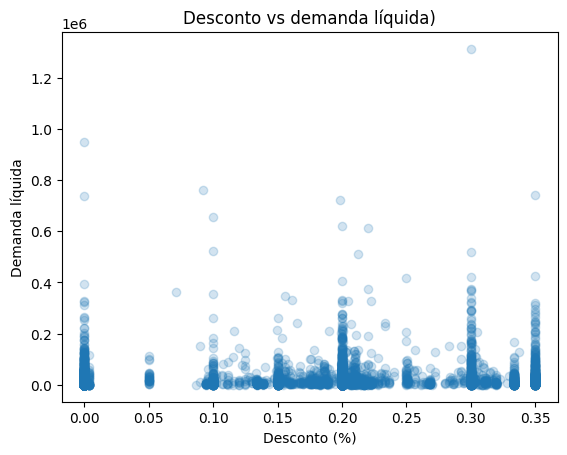

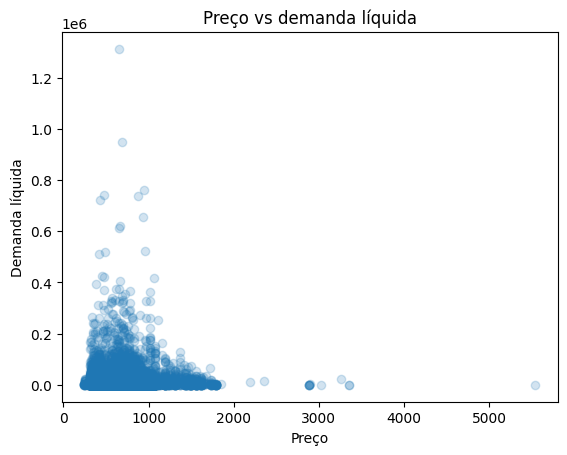

In [28]:
numeric_cols = [
    "qt_venda_liquida",
    "VL_PRECO",
    "PCT_DESCONTO",
    "VL_RECEITA_LIQUIDA",
    "pct_devolucao",
    "FLG_CAMPANHA_RESUMO",
]
numeric_cols = [c for c in numeric_cols if c in base_work.columns]

corr = base_work[numeric_cols].corr(numeric_only=True)

plt.figure(figsize=(8, 6))
plt.imshow(corr.values, aspect="auto")
plt.title("Matriz de correlação (características numéricas)")
plt.xticks(ticks=np.arange(len(numeric_cols)), labels=numeric_cols, rotation=90)
plt.yticks(ticks=np.arange(len(numeric_cols)), labels=numeric_cols)
plt.colorbar(label="corr")
plt.show()

display(corr)

# Gráfico de dispersão: desconto versus demanda

sample = base_work.sample(min(20000, len(base_work)), random_state=42)

if "PCT_DESCONTO" in sample.columns:
    plt.figure()
    plt.scatter(sample["PCT_DESCONTO"], sample["qt_venda_liquida"], alpha=0.2)
    plt.title("Desconto vs demanda líquida)")
    plt.xlabel("Desconto (%)")
    plt.ylabel("Demanda líquida")
    plt.show()

if "VL_PRECO" in sample.columns:
    plt.figure()
    plt.scatter(sample["VL_PRECO"], sample["qt_venda_liquida"], alpha=0.2)
    plt.title("Preço vs demanda líquida")
    plt.xlabel("Preço")
    plt.ylabel("Demanda líquida")
    plt.show()


A matriz de correlação mostra que a demanda líquida está fortemente associada à receita líquida, o que é esperado do ponto de vista contábil e valida a consistência dos dados. Essa correlação elevada indica que variações em volume explicam grande parte da variação em receita, reforçando que o negócio é majoritariamente “volume-driven”. Para modelagem de demanda, isso significa que a receita não deve ser usada como variável explicativa direta da quantidade, sob risco de redundância e vazamento de informação, mas sim como variável de validação de coerência do comportamento agregado.

Quando analisamos os fatores comerciais, observa-se que o percentual de desconto apresenta uma correlação positiva, porém moderada, com a demanda líquida. Isso indica que descontos tendem a impulsionar vendas, mas não de forma linear nem garantida. O efeito existe, mas é altamente dependente de contexto, como categoria, marca, canal e momento do ciclo. Essa leitura é reforçada pelo scatter plot de desconto versus demanda, que mostra grande dispersão vertical para níveis semelhantes de desconto, evidenciando que o desconto, isoladamente, não explica o volume vendido. Em termos de negócio, isso é um alerta contra políticas de desconto generalizadas esperando ganho previsível de volume.

A flag de campanha apresenta correlação forte com o percentual de desconto, o que confirma que campanhas são operacionalizadas majoritariamente via alavancas de preço. Ao mesmo tempo, a correlação entre campanha e demanda líquida é positiva, porém inferior à correlação campanha–desconto. Isso sugere que campanhas funcionam mais como um habilitador de estímulo do que como um driver direto de demanda. Ou seja, a campanha cria condições comerciais, mas o resultado final em volume depende da elasticidade específica do produto e do contexto competitivo.

O preço mostra correlação fraca e levemente negativa com a demanda líquida, o que é consistente com um cenário de elasticidade heterogênea. O gráfico de preço versus demanda evidencia que os maiores volumes estão concentrados em faixas de preço mais baixas, enquanto preços elevados apresentam volumes residuais. No entanto, a ausência de uma relação claramente linear indica que preço absoluto não captura, sozinho, o comportamento de compra; fatores como posicionamento da marca, necessidade do produto e substituibilidade são determinantes. Para planejamento de demanda, isso reforça que preço deve ser tratado como variável contextual e não como um preditor direto simples.

Por fim, a correlação negativa entre percentual de devolução e demanda, ainda que moderada, sugere que itens com maior instabilidade comercial ou operacional tendem a apresentar menor desempenho líquido. Esse fator é relevante para forecast, pois devoluções aumentam a variância efetiva da série e distorcem a leitura de demanda real.

# Correlação entre as variávies com a demanda líquida

In [29]:
# features gerais

target = "qt_venda_liquida"

numeric_features = [
    "PCT_DESCONTO",
    "VL_PRECO",
    "VL_RECEITA_LIQUIDA",
    "pct_devolucao",
]

n_bins = 5
max_categories = 10
min_obs = 30


# funções gerais

def plot_box_by_quantiles(
    df: pd.DataFrame,
    feature: str,
    target_col: str,
    q: int = 5,
    figsize: tuple = (4, 4),
) -> None:
    df_plot = df[[feature, target_col]].dropna()
    if df_plot[feature].nunique() < 2:
        return

    df_plot["bin"] = pd.qcut(df_plot[feature], q=q, duplicates="drop")
    if df_plot["bin"].nunique() < 2:
        return

    groups = df_plot.groupby("bin", observed=True)[target_col].apply(np.array)

    plt.figure(figsize=figsize)
    plt.boxplot(groups.values, showfliers=False)
    plt.xticks(
        np.arange(1, len(groups) + 1),
        [str(b) for b in groups.index],
        rotation=45,
        ha="right",
    )
    plt.title(f"Demanda líquida por quantis de {feature}")
    plt.xlabel(f"{feature} (quantis)")
    plt.ylabel(target_col)
    plt.tight_layout()
    plt.show()


def correlation_table(
    df: pd.DataFrame,
    features: list[str],
    target_col: str,
) -> pd.DataFrame:
    rows = []
    for feature in features:
        df_corr = df[[feature, target_col]].dropna()
        if df_corr[feature].nunique() < 2:
            continue

        rows.append(
            {
                "variable": feature,
                "pearson_corr": df_corr[feature].corr(df_corr[target_col], method="pearson"),
                "spearman_corr": df_corr[feature].corr(df_corr[target_col], method="spearman"),
                "n_obs": len(df_corr),
            }
        )

    corr_df = pd.DataFrame(rows)
    if corr_df.empty:
        return corr_df

    return corr_df.sort_values(by="spearman_corr", key=np.abs, ascending=False)


def detect_categorical_cols(df: pd.DataFrame, target_col: str) -> list[str]:
    cat_cols = [
        c for c in df.columns
        if (df[c].dtype == "object")
        or c.startswith(("COD_", "DES_", "FLG_"))
    ]
    return [c for c in cat_cols if c != target_col]


def plot_box_by_category(
    df: pd.DataFrame,
    feature: str,
    target_col: str,
    max_cats: int = 10,
    min_count: int = 30,
    figsize: tuple = (6, 4),
) -> None:
    df_plot = df[[feature, target_col]].dropna()

    # filtra categorias com amostra mínima
    valid = df_plot[feature].value_counts()
    valid = valid[valid >= min_count].index
    df_plot = df_plot[df_plot[feature].isin(valid)]
    if df_plot[feature].nunique() < 2:
        return

    # top categorias por volume (soma do target)
    top = (
        df_plot.groupby(feature)[target_col]
        .sum()
        .sort_values(ascending=False)
        .head(max_cats)
        .index
    )
    df_plot = df_plot[df_plot[feature].isin(top)]

    # ordena por mediana (melhor leitura)
    order = (
        df_plot.groupby(feature)[target_col]
        .median()
        .sort_values(ascending=False)
        .index
    )

    data = [df_plot.loc[df_plot[feature] == cat, target_col].values for cat in order]

    plt.figure(figsize=figsize)
    plt.boxplot(data, showfliers=False)
    plt.xticks(np.arange(1, len(order) + 1), order.astype(str), rotation=45, ha="right")
    plt.title(f"Demanda líquida por {feature} (Top {len(order)})")
    plt.xlabel(feature)
    plt.ylabel(target_col)
    plt.tight_layout()
    plt.show()



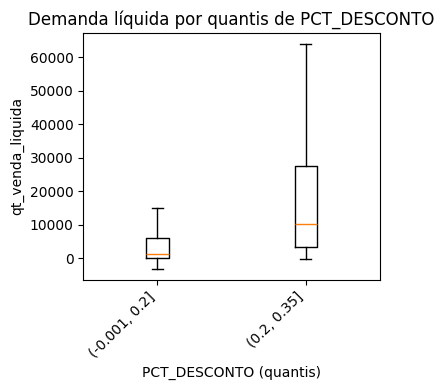

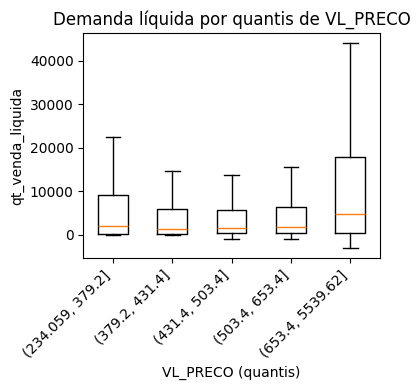

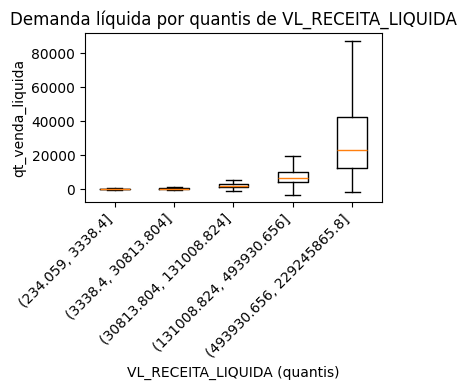

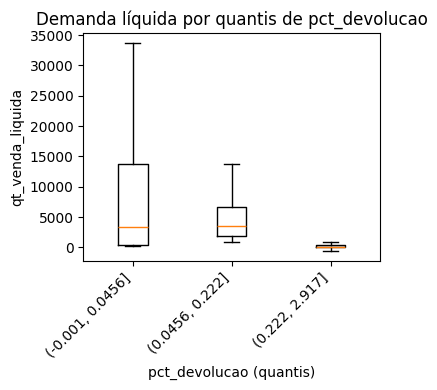

,variable,pearson_corr,spearman_corr,n_obs
2,VL_RECEITA_LIQUIDA,0.906034,0.955858,173923
0,PCT_DESCONTO,0.249118,0.478435,173923
3,pct_devolucao,-0.149003,-0.326724,173923
1,VL_PRECO,0.088679,0.075042,173923


Variáveis categóricas detectadas: ['COD_CICLO', 'FLG_DATA', 'COD_MATERIAL', 'COD_CANAL', 'DES_CATEGORIA_MATERIAL', 'DES_MARCA_MATERIAL', 'COD_REGIAO', 'FLG_CAMPANHA_MKT_A', 'FLG_CAMPANHA_MKT_B', 'FLG_CAMPANHA_MKT_C', 'FLG_CAMPANHA_MKT_D', 'FLG_CAMPANHA_MKT_E', 'FLG_CAMPANHA_RESUMO']


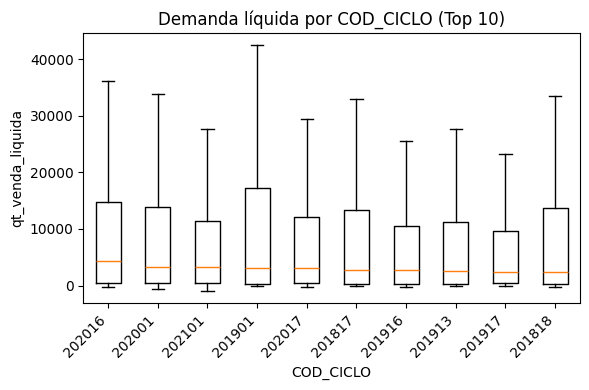

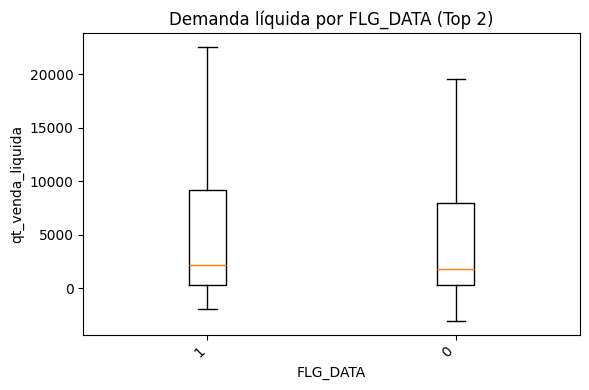

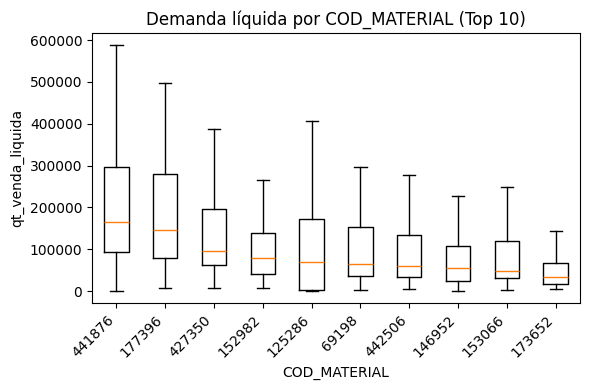

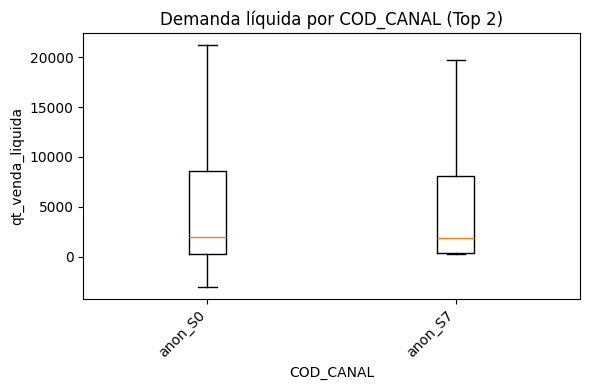

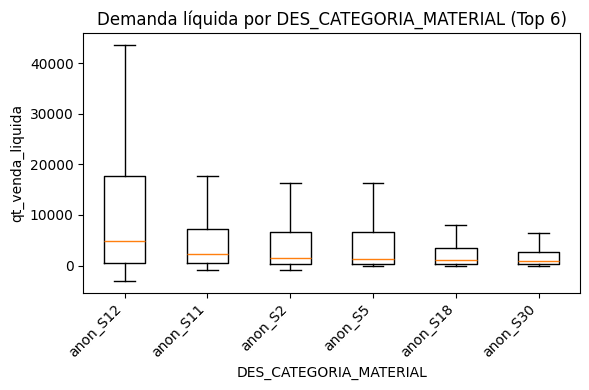

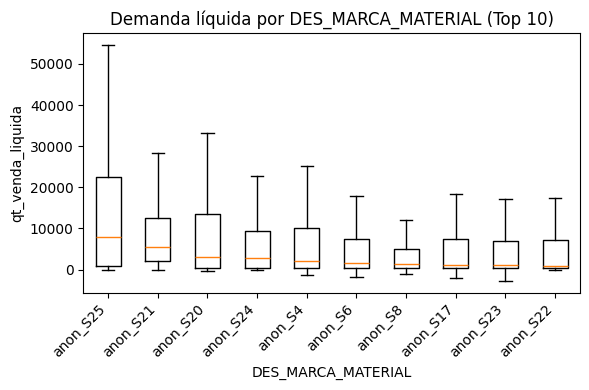

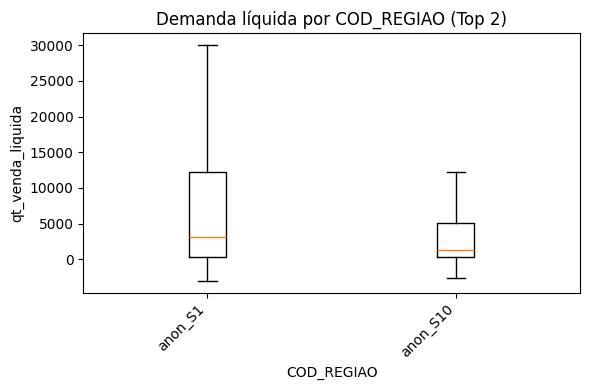

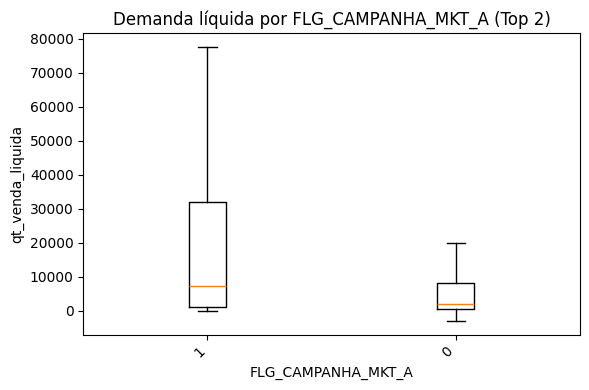

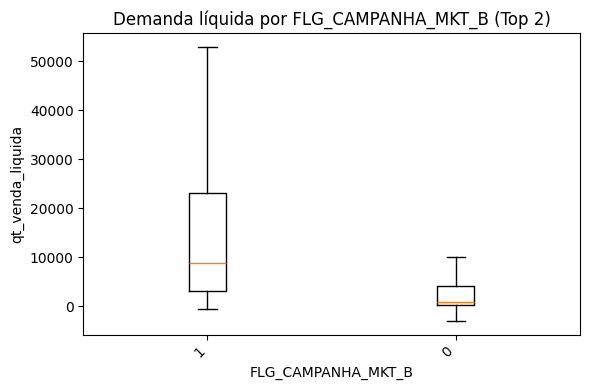

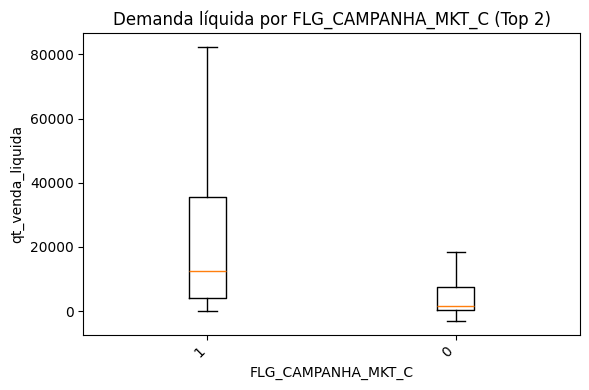

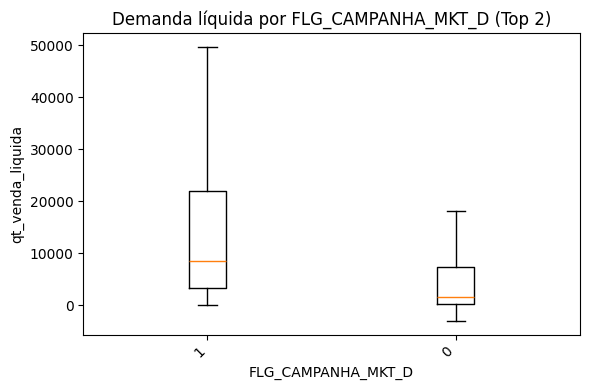

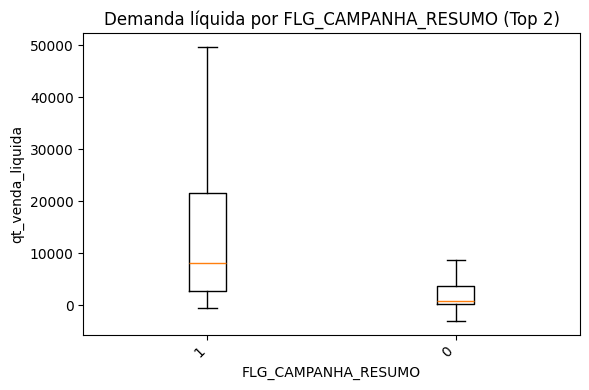

In [30]:
# 1 NUMÉRICAS: boxplot por quantis

for feature in numeric_features:
    plot_box_by_quantiles(base_work, feature, target, q=n_bins, figsize=(4, 4))



# 2 CORRELAÇÕES: Pearson/Spearman

corr_df = correlation_table(base_work, numeric_features, target)
display(corr_df)


# 3 CATEGÓRICAS: boxplot top N

categorical_cols = detect_categorical_cols(base_work, target)
print("Variáveis categóricas detectadas:", categorical_cols)

for feature in categorical_cols:
    plot_box_by_category(
        base_work,
        feature,
        target,
        max_cats=max_categories,
        min_count=min_obs,
        figsize=(6, 4),
    )

Do ponto de vista comercial, preço e desconto não deslocam apenas a média da demanda, mas alteram significativamente toda a distribuição. Maiores níveis de desconto estão associados a medianas mais altas de demanda, porém com forte aumento da dispersão e caudas longas, o que indica ganho de volume acompanhado de maior incerteza. O preço, por sua vez, apresenta efeito inverso mais difuso: faixas de preço mais baixas concentram volumes maiores e mais variáveis, enquanto faixas altas tendem a volumes menores e mais estáveis. Isso confirma que políticas comerciais afetam simultaneamente potencial de venda e risco, e não podem ser avaliadas apenas por elasticidade média.

A receita líquida sintetiza bem esse efeito, mostrando crescimento monotônico da demanda e, ao mesmo tempo, explosão da variância nos quantis superiores. Em termos de planejamento, isso significa que os itens que mais contribuem para o faturamento são também os que concentram o maior erro absoluto de previsão, devendo ser o foco prioritário de modelos mais sofisticados e de acompanhamento contínuo. Já o percentual de devolução atua como um fator de penalização claro, com quantis elevados associados a demandas baixas e menos dispersas, indicando fricção comercial ou operacional que reduz não só volume, mas previsibilidade.

No eixo temporal e estrutural, os boxplots por ciclo e por flags de data mostram que a demanda opera em regimes distintos, com alguns períodos apresentando medianas mais altas e caudas muito mais longas. Isso reforça a presença de sazonalidade e eventos que impactam não apenas o nível médio, mas a variância da demanda, invalidando a suposição de comportamento estacionário ao longo do tempo.

Ao incorporar a análise por região, observa-se que a região líder apresenta não apenas maior mediana de demanda, mas também uma dispersão significativamente superior, com caudas longas. Isso indica que essa região concentra o maior impacto absoluto no negócio e, simultaneamente, o maior risco. A região secundária, embora relevante, apresenta comportamento mais contido. Do ponto de vista de demanda, isso implica que erros de forecast na região dominante têm efeito maior sobre estoque, nível de serviço e capital de giro.

A análise das flags de campanha (MKT A, B, C e D) é particularmente elucidativa quando combinada com os achados anteriores. Em todos os casos, a condição com campanha ativa apresenta medianas substancialmente mais altas e uma explosão da variabilidade, enquanto a ausência de campanha está associada a volumes mais baixos e distribuições mais concentradas. Isso demonstra que campanhas são um forte amplificador de demanda, mas também um amplificador de incerteza. Em outras palavras, campanhas aumentam o upside, mas também elevam o risco de ruptura ou excesso de estoque se tratadas com parâmetros estáticos.

Quando se cruza essa leitura com os boxplots por material, categoria, marca e canal, o padrão se repete: poucos itens, categorias ou marcas concentram grandes volumes e alta variabilidade absoluta, enquanto a cauda longa apresenta baixos volumes, porém alta variabilidade relativa. Isso confirma que o risco financeiro está concentrado nos itens core, enquanto o risco operacional e a complexidade estão espalhados pelo portfólio longo.

Em síntese, a análise mostra que a demanda líquida é governada por efeitos condicionais e assimétricos, onde região, campanha, preço e desconto deslocam simultaneamente o nível e a dispersão da demanda. Para o negócio, políticas de previsão e estoque devem ser segmentadas por risco, com modelos e estoques de segurança dinâmicos para regiões e períodos de campanha, foco analítico nos itens de maior volume e abordagens mais simples e agregadas para a cauda do portfólio.